# Mario EEG —  QC Report

**Processing Pipeline with  Quality Control**

## Sections Overview

1. **Setup & Configuration** - Import libraries and set paths
2. **Data Loading** - Load raw EEG data and basic info
3. **Raw Data QC** - Sensor layout, PSD, amplitude distribution
4. **Filtering** - Apply bandpass and notch filters with QC
5. **First AutoReject Pass** - Epoch rejection and interpolation analysis
6. **ICA Decomposition** - Fit ICA on clean epochs
7. **ICLabel Classification** - Automated component labeling and exclusion
8. **Second AutoReject Pass** - Re-evaluate after ICA cleaning
9. **Final QC Analysis** - Comprehensive before/after comparisons
10. **Generate Reports** - HTML and PDF output with all QC metrics

> Each section contains its own helper functions for clarity.


## 1. Setup & Configuration


In [1]:
import warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from typing import Dict, Tuple, Optional, List
from IPython.display import display

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("INFO")

# ===================== CONFIGURATION =====================
# File paths
FNAME = r"D:\Yann\neurotheque_resources\data\mario\eeg\sub-01_ses-001_task-mario-eeg_run-01_raw.edf"
OUT_DIR = Path("qc_report_mario_enhanced")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Processing parameters
LINE_FREQ = 60          # Line frequency (60 Hz for North America, 50 Hz for Europe)
HP, LP = 1, 40          # Bandpass filter parameters
EPOCH_DUR = 2.0         # Epoch duration in seconds
EPOCH_OVERLAP = 0.0     # Epoch overlap in seconds

# ICLabel thresholds
EYE_THRESH = 0.7        # Threshold for eye blink components
MUSCLE_THRESH = 0.8     # Threshold for muscle artifact components

# Figure collection system for organized report generation
REPORT_SECTIONS = {
    "01_Setup": "Setup & Configuration",
    "02_Raw": "Raw Data Analysis", 
    "03_Filtering": "Filtering",
    "04_AutoReject1": "First AutoReject Pass",
    "05_ICA": "ICA Decomposition",
    "06_ICLabel": "ICLabel Classification",
    "07_AutoReject2": "Second AutoReject Pass",
    "08_FinalQC": "Final QC Analysis",
    "09_Metrics": "Summary Metrics"
}

# Initialize figure storage
FIGS = {section: [] for section in REPORT_SECTIONS}

def add_fig(fig, title: str, section: str):
    """Add a figure to the report collection."""
    if section not in FIGS:
        print(f"Warning: Unknown section '{section}'. Adding to '09_Metrics'.")
        section = "09_Metrics"
    FIGS[section].append((title, fig))

print(f"Configuration loaded successfully")
print(f"Input file: {FNAME}")
print(f"Output directory: {OUT_DIR.resolve()}")
print(f"Processing parameters: {HP}-{LP} Hz bandpass, {LINE_FREQ} Hz notch")
print(f"Epoch parameters: {EPOCH_DUR}s duration, {EPOCH_OVERLAP}s overlap")


Configuration loaded successfully
Input file: D:\Yann\neurotheque_resources\data\mario\eeg\sub-01_ses-001_task-mario-eeg_run-01_raw.edf
Output directory: D:\Yann\neurotheque_resources\notebooks\preprocessing\qc_report_mario_enhanced
Processing parameters: 1-40 Hz bandpass, 60 Hz notch
Epoch parameters: 2.0s duration, 0.0s overlap


## 2. Data Loading


In [2]:
# Load raw EEG data
raw = mne.io.read_raw_edf(FNAME, preload=True)

# Harmonize channel names
raw.rename_channels(lambda x: x.replace("EEG ", "").replace("-Pz", ""))

# Drop unnecessary channels
for ch in ['CM', 'X1', 'X2', 'X3']:
    if ch in raw.ch_names:
        raw.drop_channels([ch])

# Set channel types
raw.set_channel_types({ch: 'misc' for ch in ['A1', 'A2'] if ch in raw.ch_names})

# Set montage
raw.set_montage('standard_1020')

# Set EEG reference (average reference projection)
raw.set_eeg_reference('average', projection=True)

# Extract basic information
sfreq = raw.info['sfreq']
n_channels = len(mne.pick_types(raw.info, eeg=True))
duration_min = raw.times[-1] / 60

# Channel information table
ch_types = raw.get_channel_types()
ch_info_df = pd.DataFrame({
    "Channel": raw.ch_names,
    "Type": ch_types
})

print(f"Data loaded successfully!")
print(f"Sampling rate: {sfreq:.1f} Hz")
print(f"EEG channels: {n_channels}")
print(f"Duration: {duration_min:.1f} minutes")
print("\nChannel Information:")
display(ch_info_df)


Extracting EDF parameters from D:\Yann\neurotheque_resources\data\mario\eeg\sub-01_ses-001_task-mario-eeg_run-01_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 197999  =      0.000 ...   659.997 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Data loaded successfully!
Sampling rate: 300.0 Hz
EEG channels: 18
Duration: 11.0 minutes

Channel Information:


Channel  Type
0        P3   eeg
1        C3   eeg
2        F3   eeg
3        Fz   eeg
4        F4   eeg
5        C4   eeg
6        P4   eeg
7        Cz   eeg
8        A1  misc
9       Fp1   eeg
10      Fp2   eeg
11       T3   eeg
12       T5   eeg
13       O1   eeg
14       O2   eeg
15       F7   eeg
16       F8   eeg
17       A2  misc
18       T6   eeg
19       T4   eeg
20  Trigger  stim

## 3. Raw Data QC


In [3]:
# Helper functions for Raw Data QC

def compute_psd_metrics(raw, fmin=1, fmax=60):
    """Compute PSD and extract key metrics."""
    spec = raw.compute_psd(fmin=fmin, fmax=fmax)
    psd, freqs = spec.get_data(return_freqs=True)
    
    # Calculate alpha peak
    alpha_mask = (freqs >= 8) & (freqs <= 13)
    if alpha_mask.any():
        alpha_idx = np.argmax(psd[:, alpha_mask].mean(axis=0))
        alpha_peak = freqs[alpha_mask][alpha_idx]
    else:
        alpha_peak = np.nan
    
    return spec, psd, freqs, alpha_peak

def compute_channel_amplitude_stats(raw):
    """Compute peak-to-peak amplitude statistics per channel."""
    data = raw.get_data(picks='eeg') * 1e6  # Convert to µV
    ptp = data.ptp(axis=1)
    
    stats = {
        'mean': float(ptp.mean()),
        'median': float(np.median(ptp)),
        'std': float(ptp.std()),
        'min': float(ptp.min()),
        'max': float(ptp.max()),
        'per_channel': ptp
    }
    return stats

def plot_channel_variance_topomap(raw):
    """Create topomap of channel variances."""
    data = raw.get_data(picks='eeg')
    variances = np.var(data, axis=1)
    
    fig, ax = plt.subplots(figsize=(5, 4))
    mne.viz.plot_topomap(variances, raw.info, axes=ax, show=False)
    ax.set_title('Channel Variance Distribution')
    plt.tight_layout()
    return fig


Effective window size : 6.827 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).
Raw Data QC Summary:
- Alpha peak frequency: 8.2 Hz
- Amplitude stats (µV):
  • Mean: 2175.3
  • Median: 1361.1
  • Std: 2279.0
  • Range: [782.4, 10494.8]


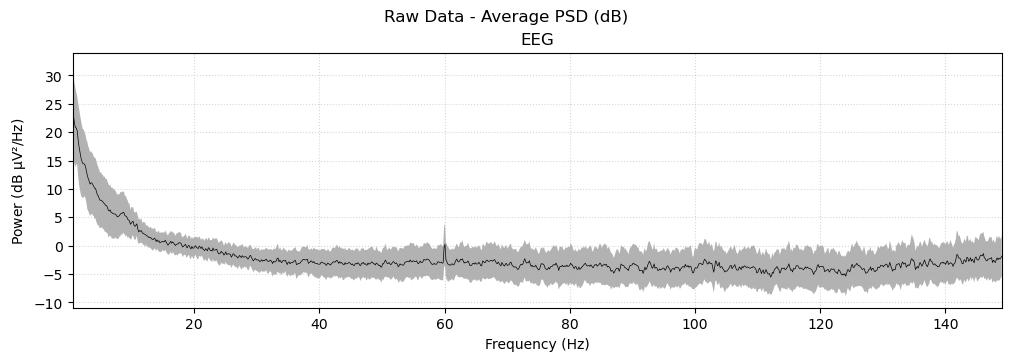

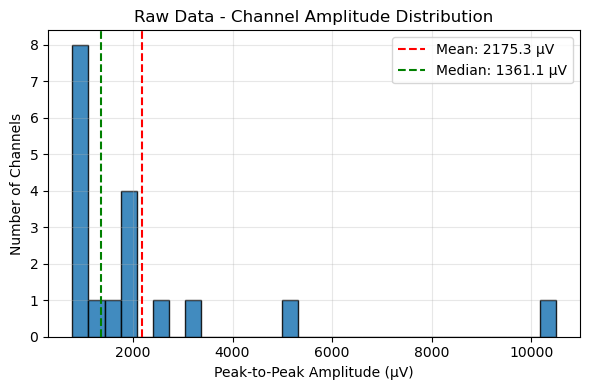

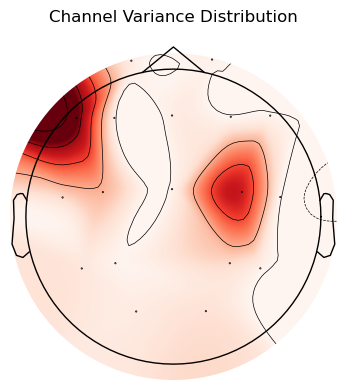

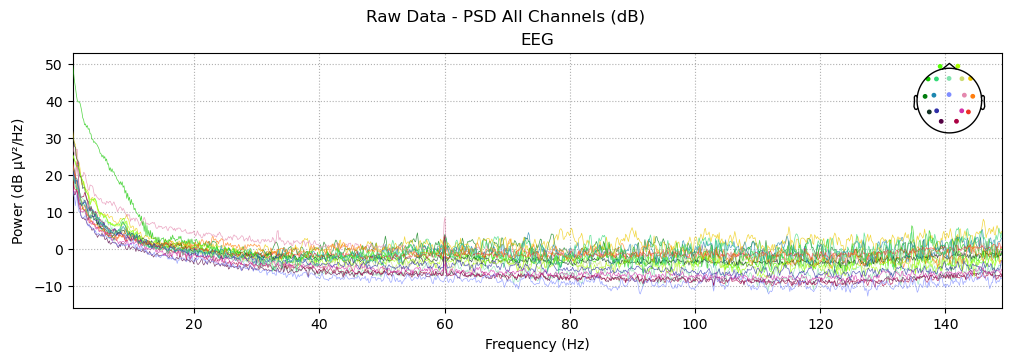

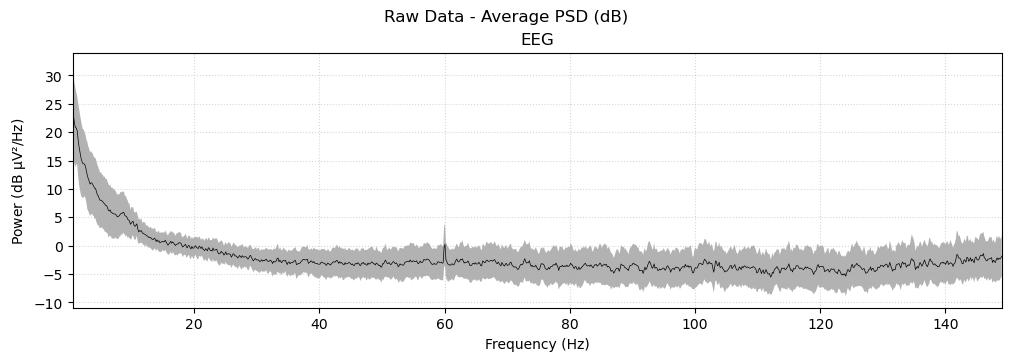

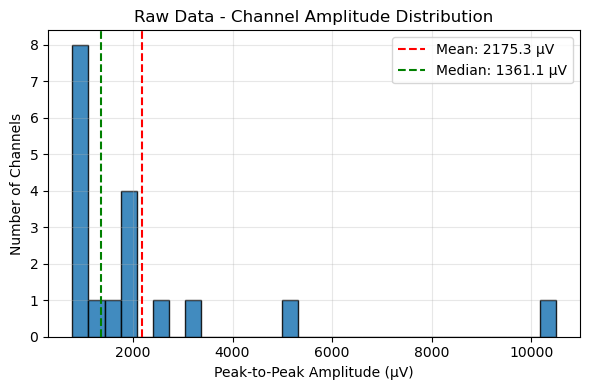

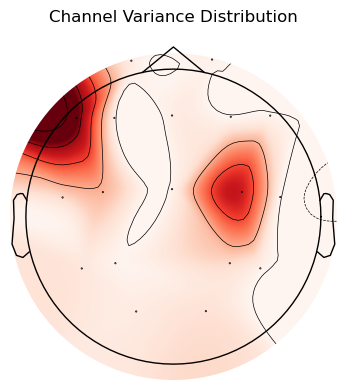

In [4]:
# Perform Raw Data QC Analysis

# 1. Compute PSD metrics
spec_raw, psd_raw, freqs_raw, alpha_peak_raw = compute_psd_metrics(raw, fmin=0.5, fmax=raw.info['sfreq']/2 - 1)

# 2. Plot PSD - all channels
fig_raw_psd_all = spec_raw.plot(picks='eeg', show=False, dB=True)
fig_raw_psd_all.suptitle('Raw Data - PSD All Channels (dB)')
add_fig(fig_raw_psd_all, 'Raw PSD - All Channels', '02_Raw')

# 3. Plot PSD - average
fig_raw_psd_avg = spec_raw.plot(average=True, picks='eeg', dB=True, show=False)
fig_raw_psd_avg.axes[0].grid(True, linestyle=':', alpha=0.5)
fig_raw_psd_avg.suptitle('Raw Data - Average PSD (dB)')
add_fig(fig_raw_psd_avg, 'Raw PSD - Average', '02_Raw')

# 4. Compute and plot amplitude statistics
amp_stats = compute_channel_amplitude_stats(raw)
fig_amp_hist = plt.figure(figsize=(6, 4))
plt.hist(amp_stats['per_channel'], bins=30, alpha=0.85, edgecolor='black')
plt.axvline(amp_stats['mean'], color='red', linestyle='--', label=f"Mean: {amp_stats['mean']:.1f} µV")
plt.axvline(amp_stats['median'], color='green', linestyle='--', label=f"Median: {amp_stats['median']:.1f} µV")
plt.xlabel('Peak-to-Peak Amplitude (µV)')
plt.ylabel('Number of Channels')
plt.title('Raw Data - Channel Amplitude Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
add_fig(fig_amp_hist, 'Raw Amplitude Distribution', '02_Raw')

# 5. Create variance topomap
fig_var_topo = plot_channel_variance_topomap(raw)
add_fig(fig_var_topo, 'Raw Channel Variance Topomap', '02_Raw')

# Print summary statistics
print(f"Raw Data QC Summary:")
print(f"- Alpha peak frequency: {alpha_peak_raw:.1f} Hz")
print(f"- Amplitude stats (µV):")
print(f"  • Mean: {amp_stats['mean']:.1f}")
print(f"  • Median: {amp_stats['median']:.1f}")
print(f"  • Std: {amp_stats['std']:.1f}")
print(f"  • Range: [{amp_stats['min']:.1f}, {amp_stats['max']:.1f}]")

# Display figures
display(fig_raw_psd_avg, fig_amp_hist, fig_var_topo)


## 4. Filtering


In [5]:
# Helper functions for Filtering QC

def apply_filters(raw, hp, lp, line_freq):
    """Apply bandpass and notch filters to raw data."""
    # Create a copy to avoid modifying original
    raw_filtered = raw.copy()
    
    # Apply bandpass filter
    raw_filtered.filter(hp, lp, fir_design='firwin', verbose=False)
    
    # Apply notch filter
    raw_filtered.notch_filter(freqs=[line_freq], fir_design='firwin', verbose=False)
    
    return raw_filtered

def plot_filter_response(raw, hp, lp, line_freq):
    """Plot the frequency response of the applied filters."""
    from scipy import signal
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    
    # Create the filter to get its coefficients
    h = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'], 
                                 l_freq=hp, h_freq=lp, fir_design='firwin', verbose=False)
    
    # Compute frequency response using scipy
    w, h_freq = signal.freqz(h, worN=2048, fs=raw.info['sfreq'])
    
    # Plot magnitude response in dB
    ax1.plot(w, 20 * np.log10(np.abs(h_freq)))
    ax1.set_title(f'Bandpass Filter Response ({hp}-{lp} Hz)')
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Magnitude (dB)')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, min(100, raw.info['sfreq']/2))
    ax1.set_ylim(-80, 5)
    
    # Show filter cutoffs
    ax1.axvline(hp, color='red', linestyle='--', alpha=0.5, label=f'HP: {hp} Hz')
    ax1.axvline(lp, color='red', linestyle='--', alpha=0.5, label=f'LP: {lp} Hz')
    ax1.axhline(-3, color='green', linestyle=':', alpha=0.5, label='-3 dB')
    ax1.legend()
    
    # Notch filter visualization
    # Create notch filter
    h_notch = mne.filter.create_filter(raw.get_data(), raw.info['sfreq'],
                                      l_freq=line_freq-1, h_freq=line_freq+1,
                                      l_trans_bandwidth=0.5, h_trans_bandwidth=0.5,
                                      method='fir', fir_design='firwin', verbose=False)
    
    # Compute notch filter response
    w_notch, h_notch_freq = signal.freqz(h_notch, worN=2048, fs=raw.info['sfreq'])
    
    # Plot notch filter response
    ax2.plot(w_notch, 20 * np.log10(np.abs(h_notch_freq)))
    ax2.set_title(f'Notch Filter Response (centered at {line_freq} Hz)')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude (dB)')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(max(0, line_freq-10), min(line_freq+10, raw.info['sfreq']/2))
    ax2.set_ylim(-60, 5)
    ax2.axvline(line_freq, color='red', linestyle='--', alpha=0.5, label=f'Notch: {line_freq} Hz')
    ax2.axhline(-3, color='green', linestyle=':', alpha=0.5, label='-3 dB')
    ax2.legend()
    
    plt.tight_layout()
    return fig

def compare_psd_before_after_filter(raw_before, raw_after, fmax=100):
    """Compare PSD before and after filtering."""
    # Compute PSDs
    psd_before = raw_before.compute_psd(fmin=0.1, fmax=fmax, picks='eeg')
    psd_after = raw_after.compute_psd(fmin=0.1, fmax=fmax, picks='eeg')
    
    # Get data for manual plotting
    psds_before, freqs_before = psd_before.get_data(return_freqs=True)
    psds_after, freqs_after = psd_after.get_data(return_freqs=True)
    
    # Average across channels
    psds_before_mean = psds_before.mean(axis=0)
    psds_after_mean = psds_after.mean(axis=0)
    
    # Convert to dB
    psds_before_db = 10 * np.log10(psds_before_mean)
    psds_after_db = 10 * np.log10(psds_after_mean)
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(freqs_before, psds_before_db, 'b-', alpha=0.7, linewidth=1.5, label='Before filtering')
    ax.plot(freqs_after, psds_after_db, 'r-', alpha=0.7, linewidth=1.5, label='After filtering')
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (dB)')
    ax.set_title('PSD Comparison: Before vs After Filtering')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0.1, fmax)
    
    # Add shaded regions for filtered frequencies
    ax.axvspan(0, 1, alpha=0.2, color='gray', label='Filtered out')
    ax.axvspan(40, fmax, alpha=0.2, color='gray')
    ax.axvline(60, color='orange', linestyle='--', alpha=0.5, label='Notch (60 Hz)')
    
    return fig


Effective window size : 6.827 (s)
Effective window size : 6.827 (s)
Effective window size : 6.827 (s)
Plotting power spectral density (dB=True).
Filtering completed:
- Bandpass: 1-40 Hz
- Notch: 60 Hz
- Filter type: FIR (firwin design)


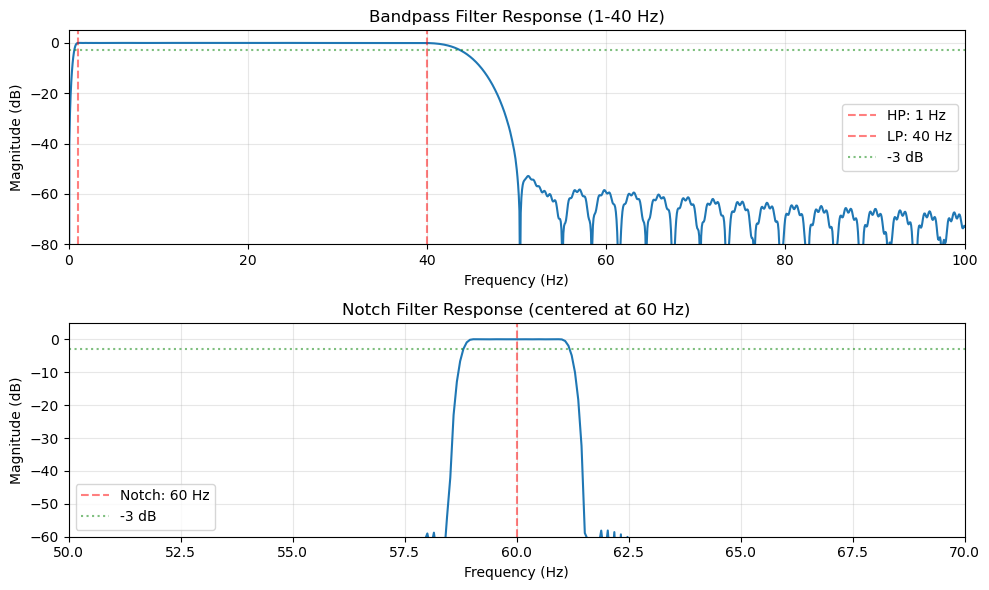

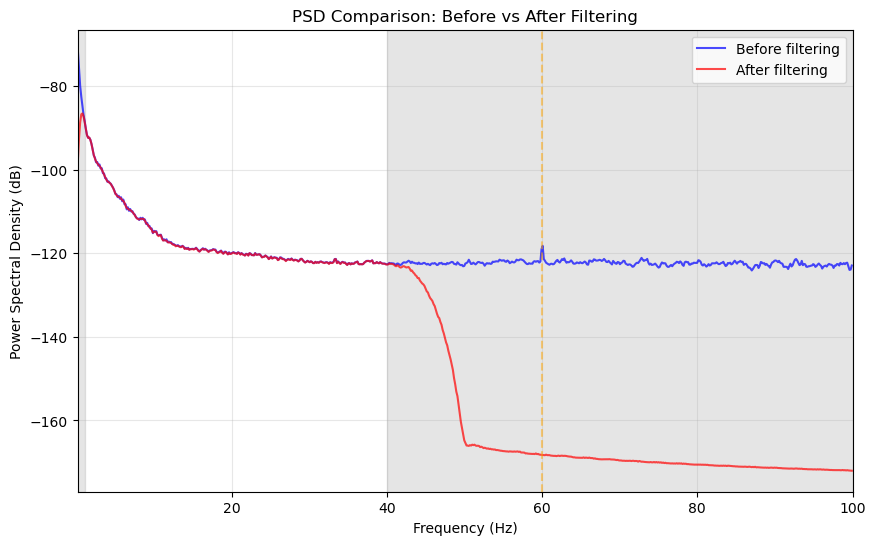

In [6]:
# Apply filtering and perform QC

# 1. Apply filters
raw_filtered = apply_filters(raw, HP, LP, LINE_FREQ)

# 2. Plot filter response
fig_filter_response = plot_filter_response(raw, HP, LP, LINE_FREQ)
add_fig(fig_filter_response, 'Filter Frequency Response', '03_Filtering')

# 3. Compare PSD before and after
fig_psd_comparison = compare_psd_before_after_filter(raw, raw_filtered, fmax=100)
add_fig(fig_psd_comparison, 'PSD Before vs After Filtering', '03_Filtering')

# 4. Filtered data PSD
spec_filtered = raw_filtered.compute_psd(fmin=0.1, fmax=60)
fig_filtered_psd = spec_filtered.plot(picks='eeg', dB=True, show=False)
fig_filtered_psd.axes[0].grid(True, linestyle=':', alpha=0.5)
fig_filtered_psd.suptitle(f'Filtered Data - PSD ({HP}-{LP} Hz bandpass, {LINE_FREQ} Hz notch)')
add_fig(fig_filtered_psd, 'Filtered Data PSD', '03_Filtering')

print(f"Filtering completed:")
print(f"- Bandpass: {HP}-{LP} Hz")
print(f"- Notch: {LINE_FREQ} Hz")
print(f"- Filter type: FIR (firwin design)")

# Display figures
display(fig_filter_response, fig_psd_comparison)


## 5. First AutoReject Pass


In [7]:
# Helper functions for AutoReject analysis

def analyze_autoreject_results(reject_log, epochs):
    """Comprehensive analysis of AutoReject results."""
    labels = np.asarray(reject_log.labels)  # (n_epochs, n_channels)
    ch_names = getattr(reject_log, 'ch_names', epochs.ch_names)
    n_ep, n_ch = labels.shape
    
    # Label meanings: 0=good, 1=bad, 2=bad+interpolated
    is_bad = (labels == 1)
    is_interp = (labels == 2)
    is_notgood = (labels != 0)
    
    # Per-channel rates
    bad_rate_ch = is_bad.mean(axis=0)
    interp_rate_ch = is_interp.mean(axis=0)
    any_notgood_rate = is_notgood.mean(axis=0)
    
    # Per-epoch stats
    frac_good_per_epoch = (labels == 0).mean(axis=1)
    n_bad_per_epoch = is_bad.sum(axis=1)
    n_interp_per_epoch = is_interp.sum(axis=1)
    n_notgood_per_epoch = is_notgood.sum(axis=1)
    
    # Bad epochs - handle both boolean array and index array cases
    bad_epochs_raw = np.asarray(reject_log.bad_epochs)
    
    # Check if it's a boolean array
    if bad_epochs_raw.dtype == bool:
        bad_epochs = np.where(bad_epochs_raw)[0]
        n_bad_epochs = bad_epochs_raw.sum()
    else:
        # It's already an array of indices
        bad_epochs = bad_epochs_raw
        n_bad_epochs = len(bad_epochs)
    
    results = {
        'labels': labels,
        'ch_names': ch_names,
        'n_epochs': n_ep,
        'n_channels': n_ch,
        'bad_rate_ch': bad_rate_ch,
        'interp_rate_ch': interp_rate_ch,
        'any_notgood_rate': any_notgood_rate,
        'frac_good_per_epoch': frac_good_per_epoch,
        'n_bad_per_epoch': n_bad_per_epoch,
        'n_interp_per_epoch': n_interp_per_epoch,
        'n_notgood_per_epoch': n_notgood_per_epoch,
        'bad_epochs': bad_epochs,
        'n_bad_epochs': int(n_bad_epochs),  # Ensure it's an int
        'bad_epochs_frac': n_bad_epochs / max(n_ep, 1)
    }
    
    return results

def plot_autoreject_channel_ranking(ar_results):
    """Plot channels ranked by not-good rate."""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ch_names = ar_results['ch_names']
    any_notgood_rate = ar_results['any_notgood_rate']
    
    # Sort by not-good rate
    order = np.argsort(any_notgood_rate)[::-1]
    
    ax.barh(np.array(ch_names)[order], 100 * any_notgood_rate[order])
    ax.invert_yaxis()
    ax.set_xlabel('Not-good rate (%) - bad OR interpolated')
    ax.set_title('Channels Ranked by AutoReject Not-Good Rate')
    ax.grid(True, axis='x', alpha=0.3)
    
    plt.tight_layout()
    return fig

def plot_autoreject_timeline(ar_results, epochs):
    """Plot data quality over time."""
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Get epoch times
    epoch_onsets_s = epochs.events[:, 0] / epochs.info['sfreq'] if epochs.events is not None else np.arange(ar_results['n_epochs']) * EPOCH_DUR
    
    ax.plot(epoch_onsets_s, ar_results['frac_good_per_epoch'], 
            marker='o', linestyle='-', markersize=4)
    ax.set_ylim(0, 1.02)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Fraction of good channels')
    ax.set_title('Data Quality Over Time (AutoReject)')
    ax.grid(True, alpha=0.3)
    
    # Highlight bad epochs
    bad_epochs = ar_results['bad_epochs']
    if len(bad_epochs) > 0:
        bad_times = epoch_onsets_s[bad_epochs]
        ax.scatter(bad_times, np.zeros(len(bad_times)), 
                  color='red', s=50, marker='x', label='Bad epochs')
        ax.legend()
    
    plt.tight_layout()
    return fig

def plot_autoreject_severity_histogram(ar_results):
    """Plot histogram of epoch severity."""
    fig, ax = plt.subplots(figsize=(8, 5))
    
    n_notgood_per_epoch = ar_results['n_notgood_per_epoch']
    n_ch = ar_results['n_channels']
    
    bins = np.arange(0, min(n_ch + 1, 30)) - 0.5
    ax.hist(n_notgood_per_epoch, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Number of bad/interpolated channels per epoch')
    ax.set_ylabel('Number of epochs')
    ax.set_title('Epoch Severity Distribution (AutoReject)')
    ax.grid(True, alpha=0.3)
    
    # Add statistics
    mean_bad = n_notgood_per_epoch.mean()
    median_bad = np.median(n_notgood_per_epoch)
    ax.axvline(mean_bad, color='red', linestyle='--', label=f'Mean: {mean_bad:.1f}')
    ax.axvline(median_bad, color='green', linestyle='--', label=f'Median: {median_bad:.0f}')
    ax.legend()
    
    plt.tight_layout()
    return fig

def plot_autoreject_bad_rate_topomap(ar_results, epochs):
    """Create topomap of channel bad rates."""
    eeg_picks = mne.pick_types(epochs.info, eeg=True)
    info_eeg = mne.pick_info(epochs.info, eeg_picks)
    
    # Use any_notgood_rate for the topomap
    bad_rates = ar_results['any_notgood_rate']
    
    # Ensure we have the right number of channels
    if len(bad_rates) == len(eeg_picks):
        values = bad_rates
    elif len(bad_rates) == len(epochs.info['ch_names']):
        values = bad_rates[eeg_picks]
    else:
        print(f"Warning: Channel count mismatch. Expected {len(eeg_picks)}, got {len(bad_rates)}")
        return None
    
    fig, ax = plt.subplots(figsize=(5, 4))
    mne.viz.plot_topomap(values, info_eeg, axes=ax, show=False)
    ax.set_title('Channel Bad Rate (AutoReject)')
    plt.tight_layout()
    return fig


Not setting metadata
330 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 330 events and 600 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Loading existing AutoReject log...
Using qt as 2D backend.

AutoReject Pass 1 Summary:
- Total epochs: 330
- Bad epochs: 52 (15.8%)
- Mean channels affected per epoch: 3.8
- Worst channels:
  • C4: 95.2% not-good rate
  • Fp1: 30.9% not-good rate
  • T5: 29.7% not-good rate
  • P3: 27.9% not-good rate
  • Fz: 27.3% not-good rate


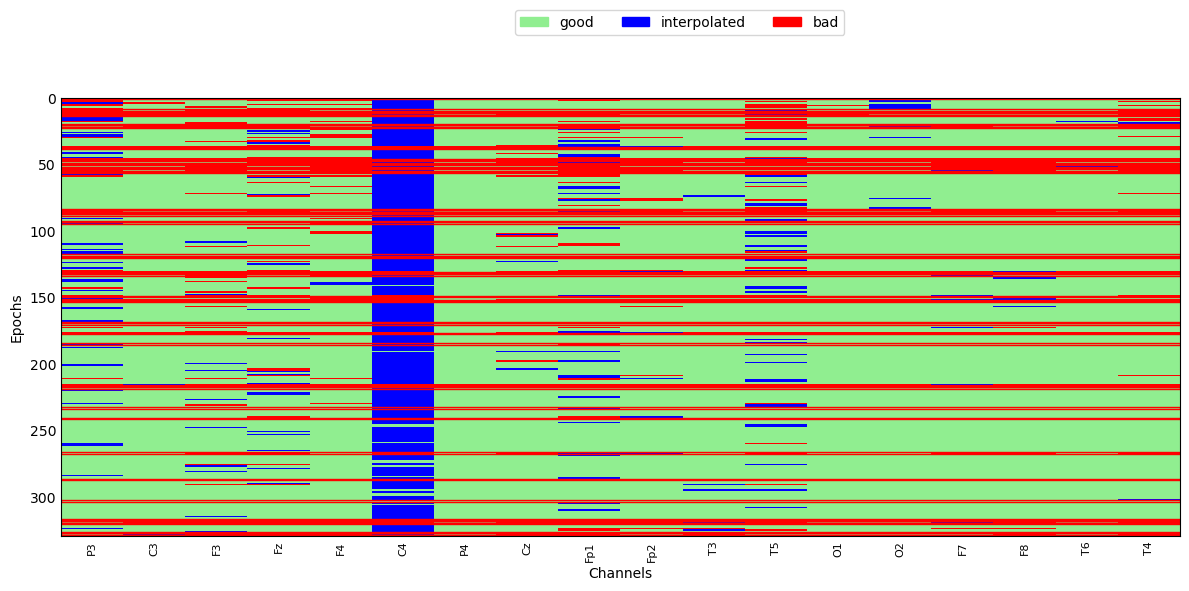

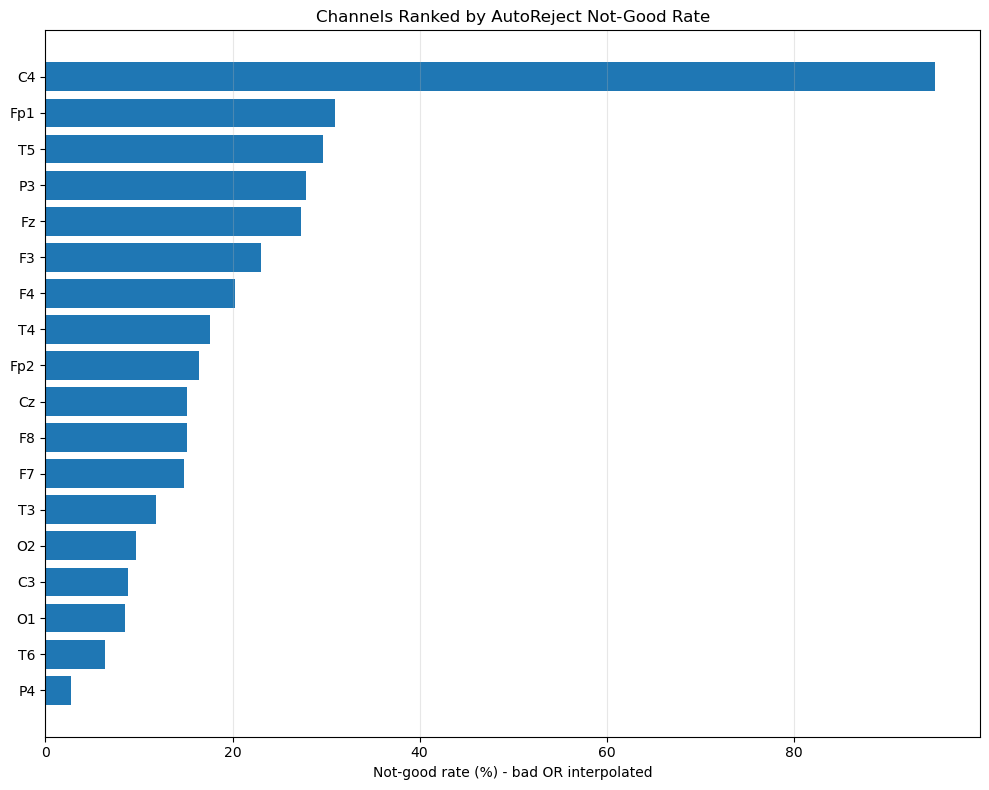

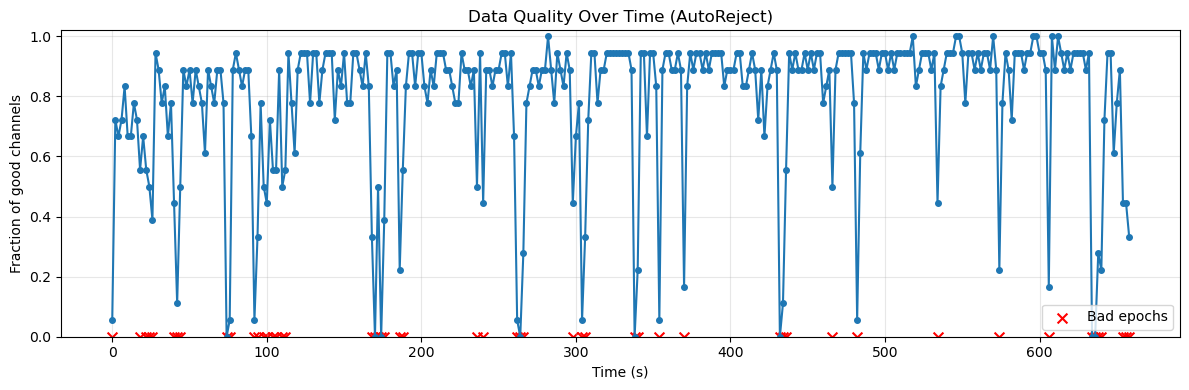

In [8]:
# Perform first AutoReject pass

from autoreject import AutoReject, read_reject_log

# Create fixed-length epochs
epochs = mne.make_fixed_length_epochs(raw_filtered, duration=EPOCH_DUR, 
                                      overlap=EPOCH_OVERLAP, preload=True)
epochs = epochs.pick_types(eeg=True)
if not epochs.info.get_montage():
    epochs.set_montage('standard_1020')

# Check for existing AutoReject log
LOG_FNAME_1 = OUT_DIR / 'ar_log_pass1.npz'
if LOG_FNAME_1.exists():
    print("Loading existing AutoReject log...")
    reject_log = read_reject_log(str(LOG_FNAME_1))
else:
    print("Running AutoReject (this may take a few minutes)...")
    ar = AutoReject(picks='eeg', 
                    n_interpolate=[1, 2, 3, 4],
                    consensus=None,
                    cv=10,
                    thresh_method='bayesian_optimization')
    ar.fit(epochs)
    reject_log = ar.get_reject_log(epochs)
    reject_log.save(str(LOG_FNAME_1), overwrite=True)

# Analyze results
ar_results_1 = analyze_autoreject_results(reject_log, epochs)

# Create visualizations
# 1. Matrix plot
fig_ar_matrix = reject_log.plot(show=False)
ax = fig_ar_matrix.axes[-1]
ax.set_aspect('auto')
fig_ar_matrix.tight_layout()
fig_ar_matrix.set_size_inches(12, 6)
add_fig(fig_ar_matrix, 'AutoReject Matrix - First Pass', '04_AutoReject1')

# 2. Channel ranking
fig_ch_rank = plot_autoreject_channel_ranking(ar_results_1)
add_fig(fig_ch_rank, 'Channel Ranking by Bad Rate', '04_AutoReject1')

# 3. Timeline
fig_timeline = plot_autoreject_timeline(ar_results_1, epochs)
add_fig(fig_timeline, 'Data Quality Timeline', '04_AutoReject1')

# 4. Severity histogram
fig_severity = plot_autoreject_severity_histogram(ar_results_1)
add_fig(fig_severity, 'Epoch Severity Distribution', '04_AutoReject1')

# 5. Bad rate topomap
fig_bad_topo = plot_autoreject_bad_rate_topomap(ar_results_1, epochs)
if fig_bad_topo is not None:
    add_fig(fig_bad_topo, 'Channel Bad Rate Topomap', '04_AutoReject1')

# 6. Epoch traces
fig_traces = reject_log.plot_epochs(epochs, 
                                   title='Epochs: Interpolated (grey) and Dropped (red)')
add_fig(fig_traces, 'Epoch Traces with AutoReject Labels', '04_AutoReject1')

# Print summary
print(f"\nAutoReject Pass 1 Summary:")
print(f"- Total epochs: {ar_results_1['n_epochs']}")
print(f"- Bad epochs: {ar_results_1['n_bad_epochs']} ({ar_results_1['bad_epochs_frac']*100:.1f}%)")
print(f"- Mean channels affected per epoch: {ar_results_1['n_notgood_per_epoch'].mean():.1f}")
print(f"- Worst channels:")
worst_ch_idx = np.argsort(ar_results_1['any_notgood_rate'])[-5:][::-1]
for idx in worst_ch_idx:
    ch_name = ar_results_1['ch_names'][idx]
    rate = ar_results_1['any_notgood_rate'][idx] * 100
    print(f"  • {ch_name}: {rate:.1f}% not-good rate")

# Display key figures
display(fig_ar_matrix, fig_ch_rank, fig_timeline)


## 6. ICA Decomposition


Dropped 52 epochs: 0, 9, 11, 12, 13, 20, 21, 22, 37, 38, 46, 47, 49, 50, 52, 53, 55, 56, 84, 85, 86, 87, 88, 93, 94, 118, 120, 131, 132, 133, 149, 152, 153, 169, 170, 177, 185, 216, 217, 218, 233, 241, 267, 287, 303, 317, 318, 319, 320, 327, 328, 329
Dropped 52 bad epochs for ICA fitting
Fitting ICA (this may take a few minutes)...
Fitting ICA to data using 18 channels (please be patient, this may take a while)
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by non-zero PCA components: 17 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 22.9s.
ICA fitted with 17 components


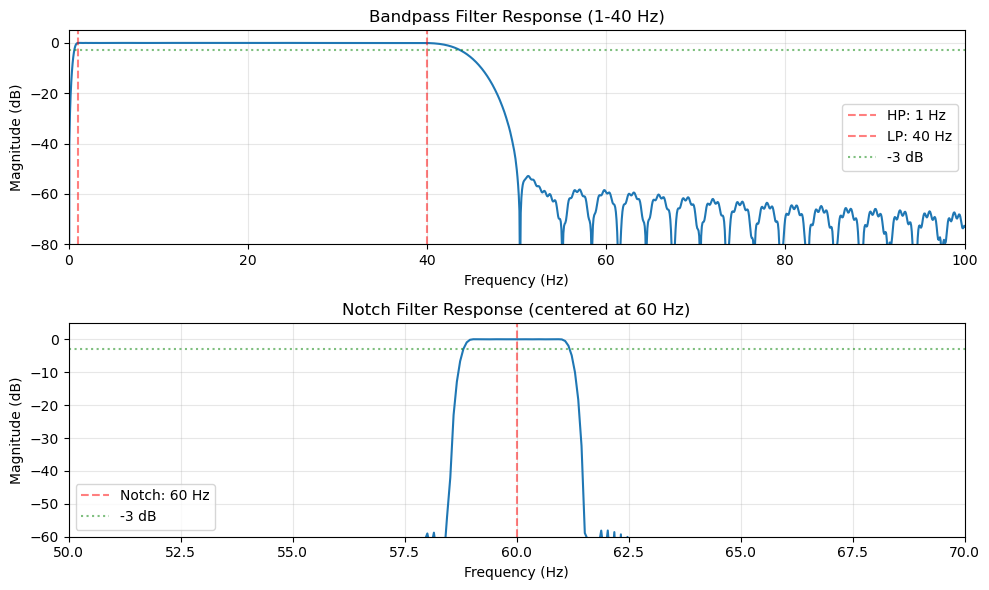

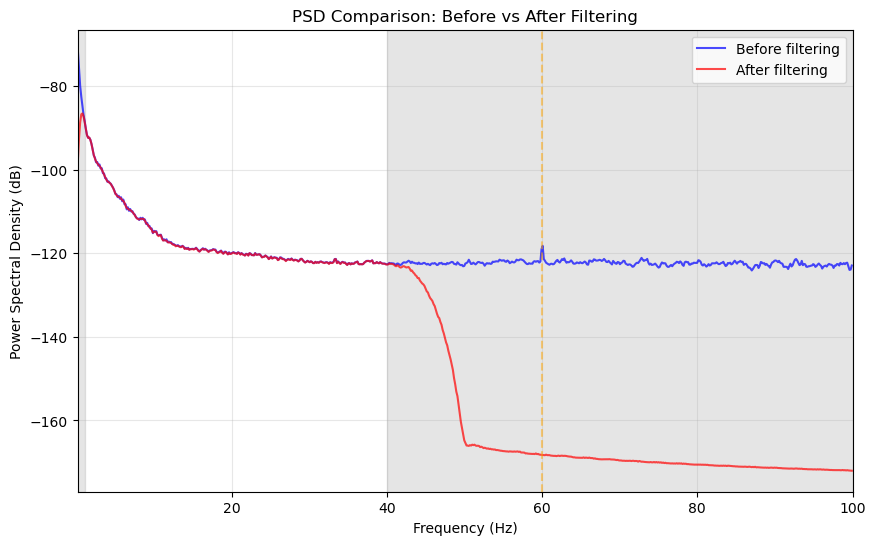

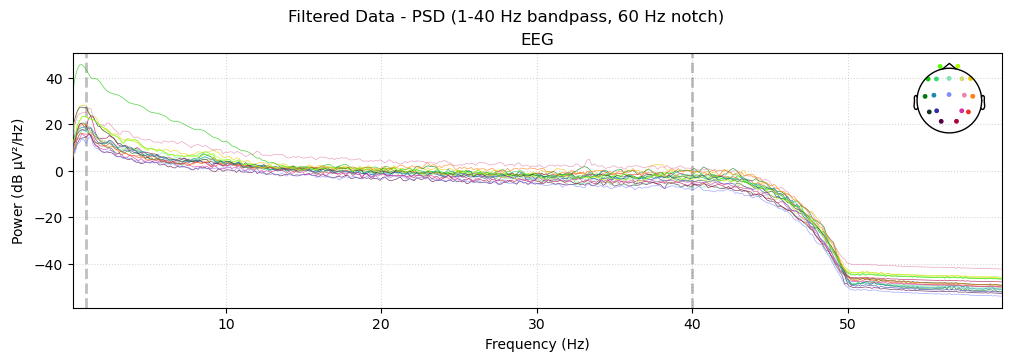

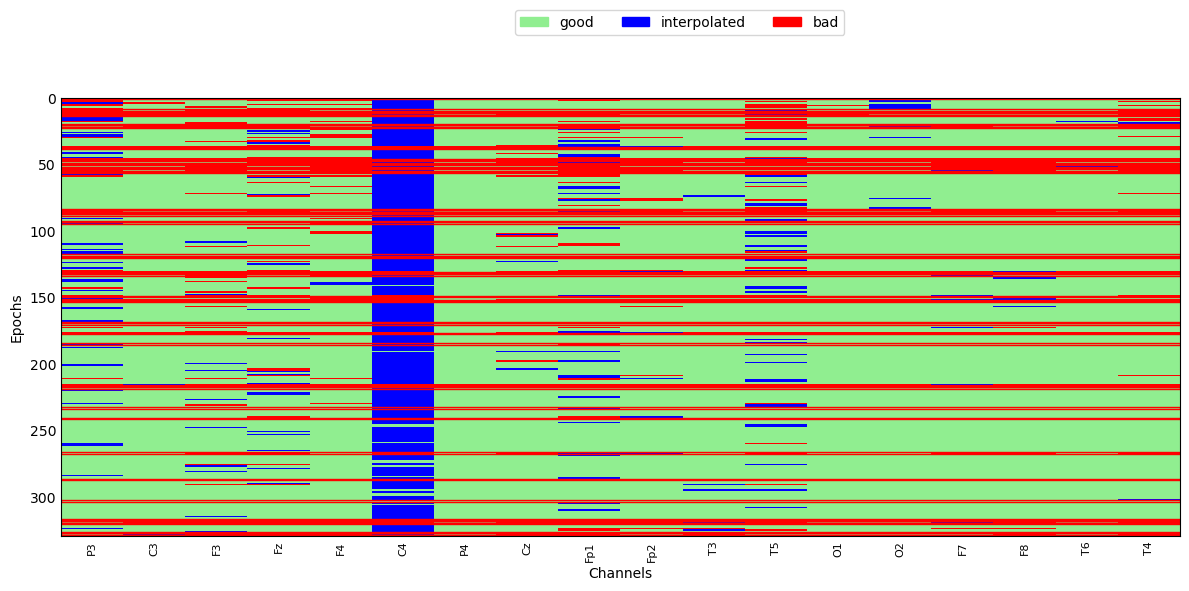

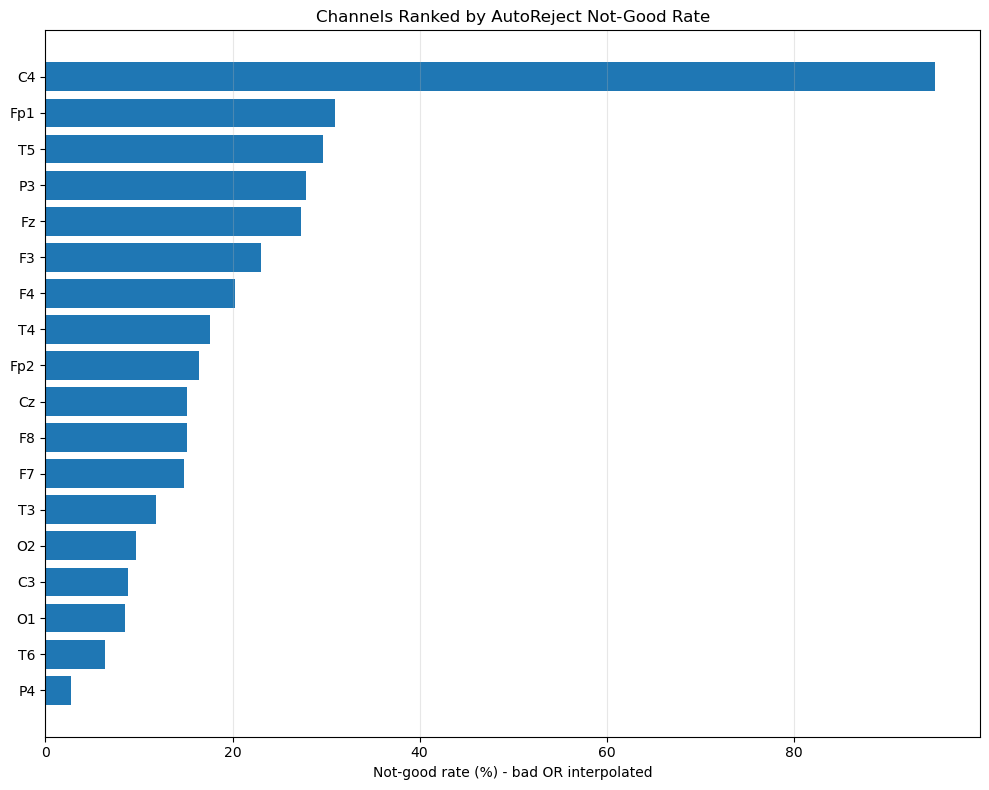

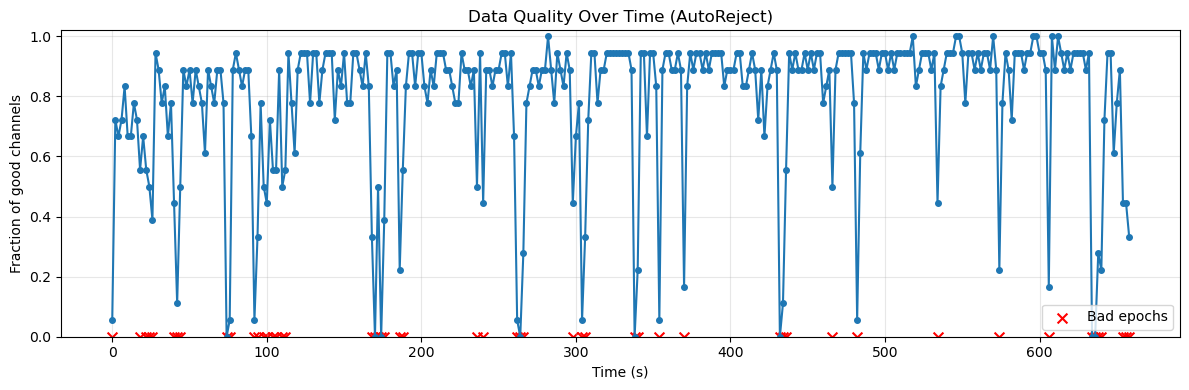

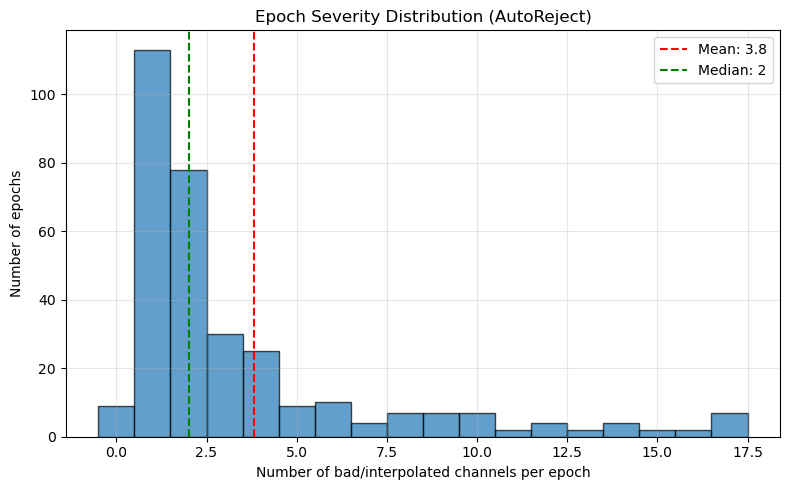

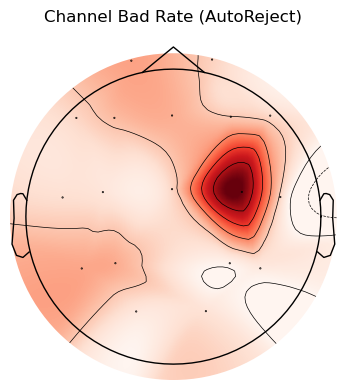

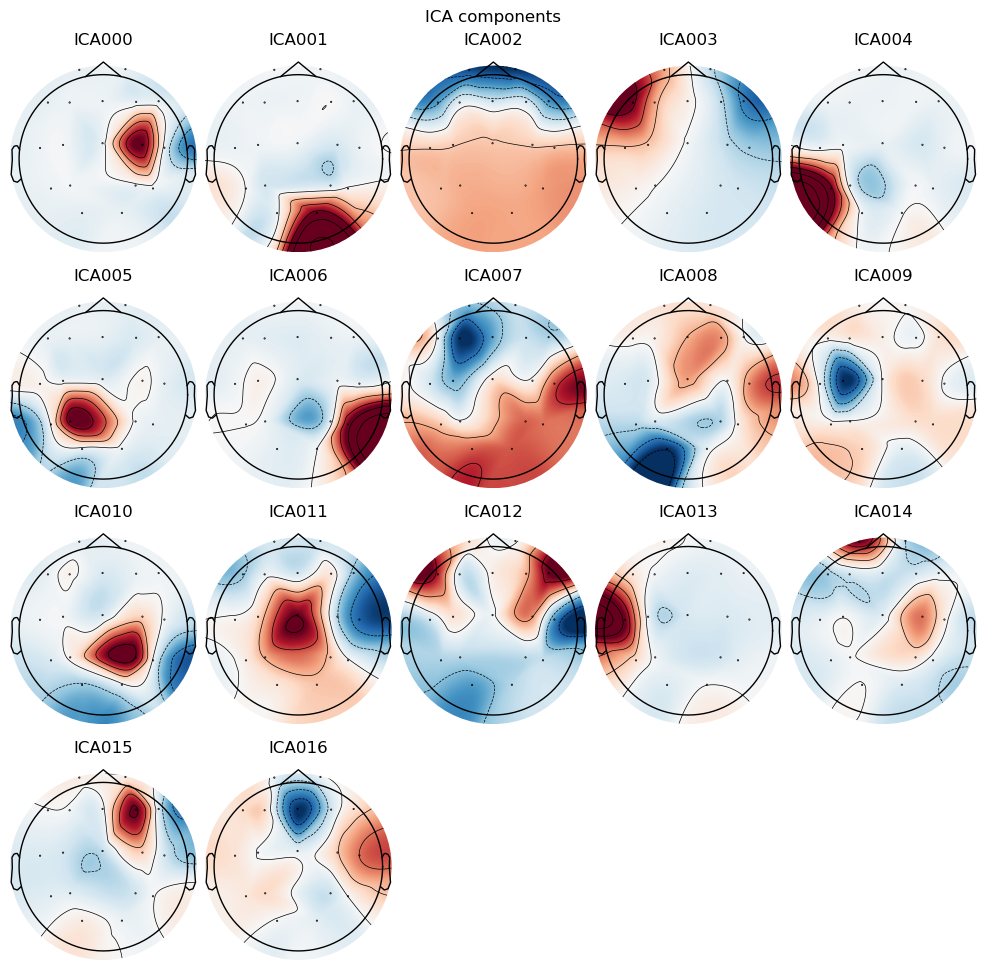

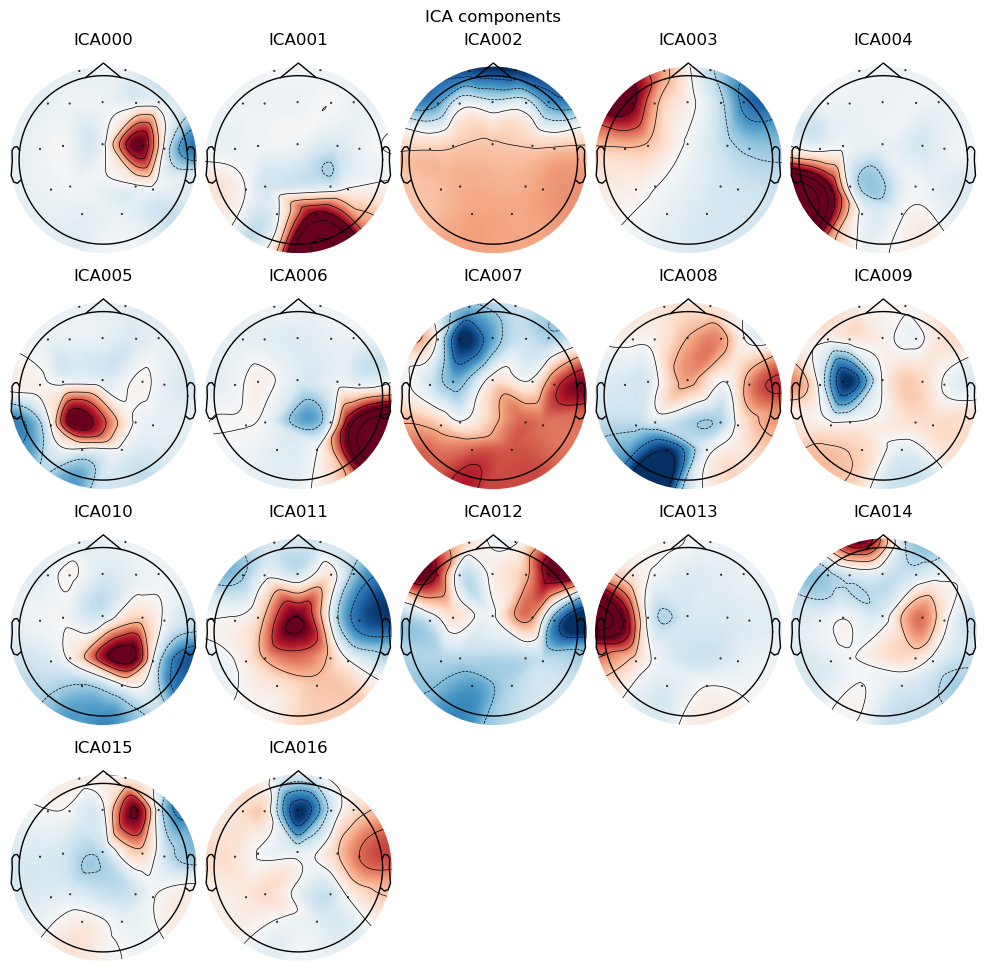

In [9]:
# Fit ICA on good epochs only

# Create clean epochs for ICA
good_epochs = epochs.copy()
if len(ar_results_1['bad_epochs']) > 0:
    good_epochs.drop(ar_results_1['bad_epochs'])
    print(f"Dropped {len(ar_results_1['bad_epochs'])} bad epochs for ICA fitting")


# Fit ICA
print("Fitting ICA (this may take a few minutes)...")
ica = mne.preprocessing.ICA(n_components=None, 
                           random_state=97, 
                           max_iter=2000, 
                           method='picard', 
                           fit_params=dict(ortho=False, extended=True))
ica.fit(good_epochs)

# Plot component maps
print(f"ICA fitted with {ica.n_components_} components")
figs_ica_maps = mne.viz.plot_ica_components(ica, res=500)
if not isinstance(figs_ica_maps, (list, tuple)):
    figs_ica_maps = [figs_ica_maps]

# Add figures to report
for i, fig in enumerate(figs_ica_maps):
    add_fig(fig, f'ICA Component Maps - Page {i+1}', '05_ICA')

# Display first page
if figs_ica_maps:
    display(figs_ica_maps[0])


## 7. ICLabel Classification


In [10]:
# Helper functions for ICLabel analysis

def plot_iclabel_heatmap(probabilities, classes, ica_exclude=None, title="ICLabel Class Probabilities"):
    """Create heatmap of ICLabel probabilities."""
    n_ic, n_cls = probabilities.shape
    ica_exclude = set(ica_exclude or [])
    
    fig_h = min(0.35 * n_ic + 2.0, 18.0)
    fig_w = max(8.0, 1.2 * n_cls + 3.0)
    
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(probabilities, aspect="auto", interpolation="nearest", 
                   cmap="viridis", vmin=0.0, vmax=1.0)
    
    # Set ticks and labels
    ax.set_xticks(range(n_cls))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticks(range(n_ic))
    ax.set_yticklabels([f"IC{k:02d}" for k in range(n_ic)])
    
    # Mark top class for each component
    for i in range(n_ic):
        j = int(probabilities[i].argmax())
        ax.text(j, i, "●", ha="center", va="center", 
                color="white", fontsize=8, fontweight="bold")
        
        # Highlight excluded components
        if i in ica_exclude:
            ax.get_yticklabels()[i].set_color("red")
            ax.get_yticklabels()[i].set_weight("bold")
    
    ax.set_ylim(n_ic - 0.5, -0.5)
    ax.set_xlim(-0.5, n_cls - 0.5)
    ax.set_title(title)
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
    cbar.set_label("Probability")
    
    plt.tight_layout()
    return fig

def plot_iclabel_distribution(labels, classes):
    """Plot pie chart of ICLabel class distribution."""
    from collections import Counter
    
    cnt = Counter(labels)
    if not cnt:
        return None
    
    # Sort by count
    labels_sorted, counts = zip(*sorted(cnt.items(), key=lambda x: -x[1]))
    
    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(counts, labels=labels_sorted, autopct='%1.0f%%',
                                      startangle=90)
    
    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    ax.set_title('ICLabel Component Class Distribution')
    plt.tight_layout()
    return fig

def apply_iclabel_thresholds(probabilities, classes, thresholds):
    """Apply thresholds to identify components to exclude."""
    exclude_indices = []
    exclude_reasons = {}
    
    for comp_idx in range(probabilities.shape[0]):
        for class_name, threshold in thresholds.items():
            if class_name in classes:
                class_idx = classes.index(class_name)
                if probabilities[comp_idx, class_idx] >= threshold:
                    exclude_indices.append(comp_idx)
                    exclude_reasons[comp_idx] = (class_name, probabilities[comp_idx, class_idx])
                    break  # Only exclude for first matching criterion
    
    return exclude_indices, exclude_reasons


Running ICLabel classification...


C:\Users\s\AppData\Local\Temp\ipykernel_26728\1669569152.py:65: UserWarning: The figure layout has changed to tight
  fig.tight_layout()



ICLabel Summary:
- Total components: 17
- Components excluded: 2

Excluded components:
  • IC02: eye blink (p=0.82)
  • IC03: eye blink (p=0.99)

Class distribution:
  • brain: 11 (64.7%)
  • other: 4 (23.5%)
  • eye blink: 2 (11.8%)


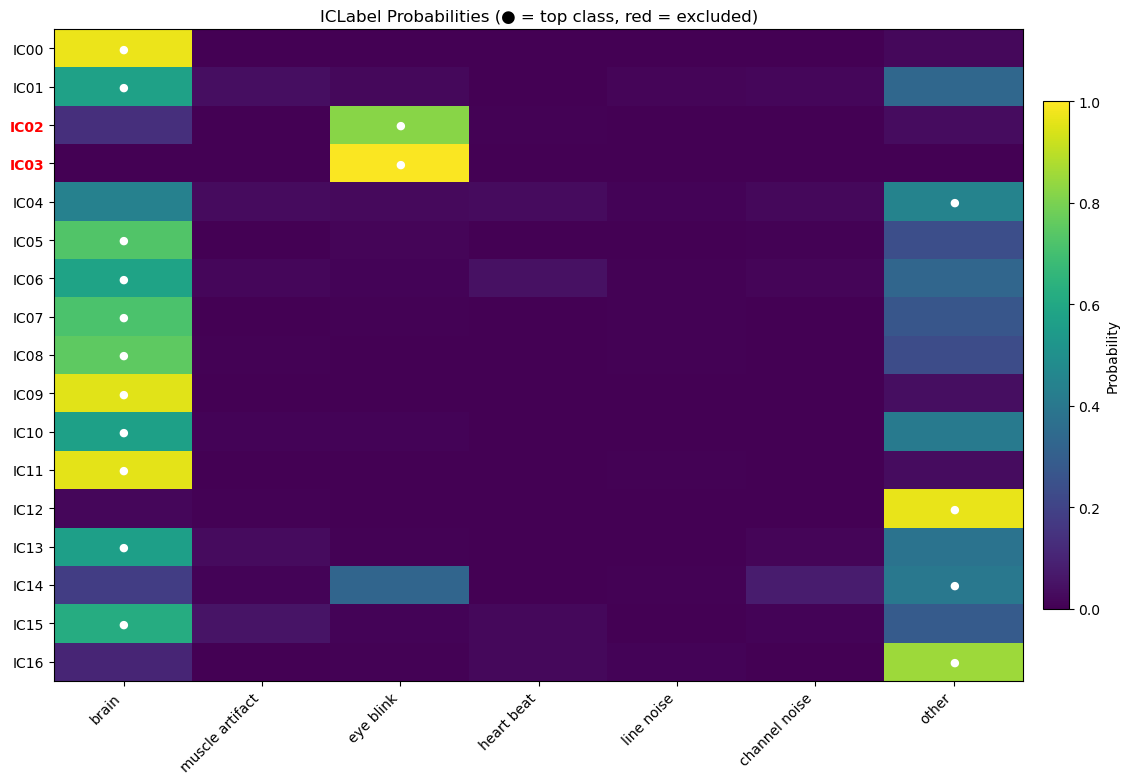

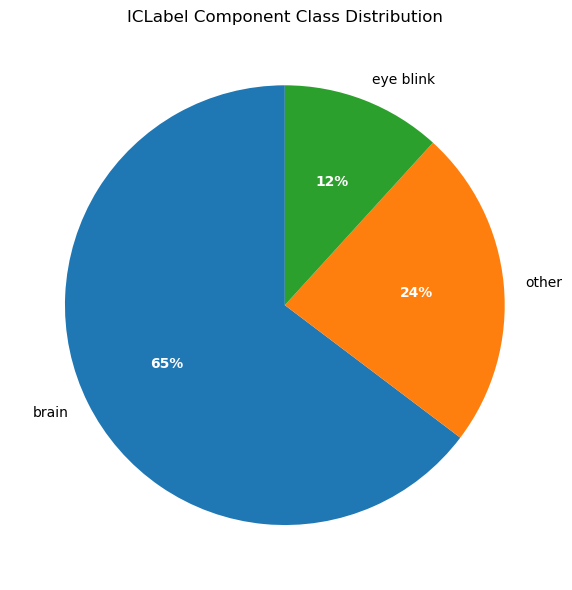

In [11]:
# Run ICLabel classification

from mne_icalabel.iclabel import iclabel_label_components
from matplotlib.patches import Rectangle

# Define ICLabel classes
ICLABEL_CLASSES = ['brain', 'muscle artifact', 'eye blink', 'heart beat', 
                   'line noise', 'channel noise', 'other']

# Run ICLabel
print("Running ICLabel classification...")
probabilities = iclabel_label_components(good_epochs, ica, inplace=False)

# Extract top classifications
top_class_idx = probabilities.argmax(axis=1)
top_class_prob = probabilities.max(axis=1)
labels_per_ic = [ICLABEL_CLASSES[j] for j in top_class_idx]

# Apply thresholds
thresholds = {
    'eye blink': EYE_THRESH,
    'muscle artifact': MUSCLE_THRESH
}
exclude_indices, exclude_reasons = apply_iclabel_thresholds(probabilities, ICLABEL_CLASSES, thresholds)
ica.exclude = list(exclude_indices)

# Create visualizations
# 1. Probability heatmap
fig_heatmap = plot_iclabel_heatmap(probabilities, ICLABEL_CLASSES, 
                                  ica_exclude=ica.exclude,
                                  title='ICLabel Probabilities (● = top class, red = excluded)')
add_fig(fig_heatmap, 'ICLabel Probability Heatmap', '06_ICLabel')

# 2. Class distribution
fig_dist = plot_iclabel_distribution(labels_per_ic, ICLABEL_CLASSES)
if fig_dist:
    add_fig(fig_dist, 'ICLabel Class Distribution', '06_ICLabel')

# 3. Component maps with labels and exclusion marks
picks = np.arange(ica.n_components_)
excluded_set = set(ica.exclude)

# Plot components with labels
figs = ica.plot_components(picks=picks, inst=good_epochs, show=False, 
                          extrapolate='head', res=500)
if not isinstance(figs, (list, tuple)):
    figs = [figs]

# Split picks per figure
picks_per_fig = np.array_split(picks, len(figs))

# Add labels and borders to excluded components
for fig, these_picks in zip(figs, picks_per_fig):
    for ax, k in zip(fig.axes, these_picks):
        k = int(k)
        ax.set_title(f"IC{k:03d} — {labels_per_ic[k]} ({top_class_prob[k]:.2f})", 
                    fontsize=9)
        
        # Add red border for excluded components
        if k in excluded_set:
            ax.add_patch(Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                                 fill=False, edgecolor='red', linewidth=2))
    
    fig.suptitle('ICA Components — ICLabel Classification (red = excluded)', fontsize=12)
    fig.tight_layout()

# Add labeled component figures to report
for i, fig in enumerate(figs):
    add_fig(fig, f'ICLabel Components - Page {i+1}', '06_ICLabel')

# Print summary
print(f"\nICLabel Summary:")
print(f"- Total components: {ica.n_components_}")
print(f"- Components excluded: {len(ica.exclude)}")
print(f"\nExcluded components:")
for comp_idx in sorted(ica.exclude):
    reason, prob = exclude_reasons[comp_idx]
    print(f"  • IC{comp_idx:02d}: {reason} (p={prob:.2f})")

print(f"\nClass distribution:")
from collections import Counter
class_counts = Counter(labels_per_ic)
for class_name, count in class_counts.most_common():
    print(f"  • {class_name}: {count} ({count/len(labels_per_ic)*100:.1f}%)")

# Display key figures
display(fig_heatmap)
if fig_dist:
    display(fig_dist)


## 8. Second AutoReject Pass


Applying ICA with 2 excluded components...
Applying ICA to Raw instance
    Applying projection operator with 1 vector (pre-whitener application)
    Transforming to ICA space (17 components)
    Zeroing out 2 ICA components
    Projecting back using 18 PCA components
Not setting metadata
330 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 330 events and 600 original time points ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Loading existing second AutoReject log...

AutoReject Comparison:
Pass 1 (before ICA):
  - Bad epochs: 52 (15.8%)
  - Mean affected channels: 3.8

Pass 2 (after ICA):
  - Bad epochs: 40 (12.1%)
  - Mean affected channels: 3.2

Improvement:
  - Bad epochs reduced by: 12
  - Affected channels reduced by: 0.6


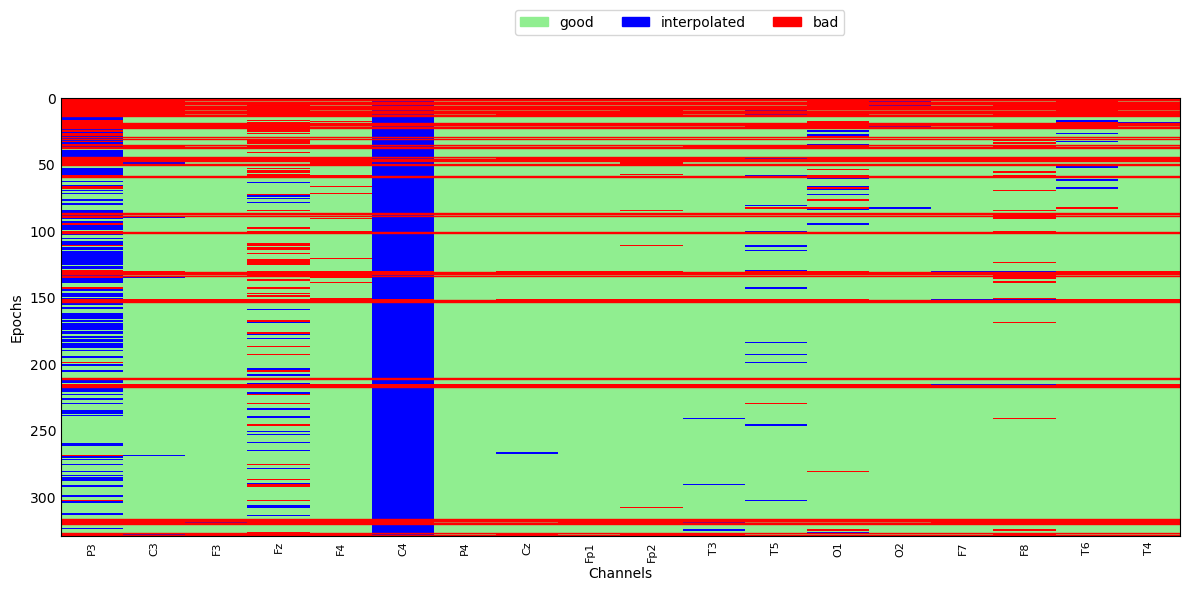

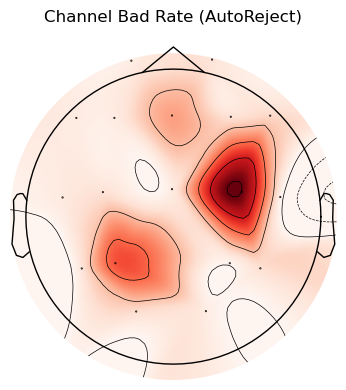

In [12]:
# Apply ICA and run second AutoReject pass

# Apply ICA to remove artifacts
print(f"Applying ICA with {len(ica.exclude)} excluded components...")
raw_clean = ica.apply(raw_filtered.copy())

# Create new epochs from cleaned data
epochs_clean = mne.make_fixed_length_epochs(raw_clean, duration=EPOCH_DUR, 
                                           overlap=EPOCH_OVERLAP, preload=True)
epochs_clean = epochs_clean.pick_types(eeg=True)
if not epochs_clean.info.get_montage():
    epochs_clean.set_montage('standard_1020')

# Run second AutoReject pass
LOG_FNAME_2 = OUT_DIR / 'ar_log_pass2.npz'
if LOG_FNAME_2.exists():
    print("Loading existing second AutoReject log...")
    reject_log2 = read_reject_log(str(LOG_FNAME_2))
else:
    print("Running second AutoReject pass (this may take a few minutes)...")
    ar2 = AutoReject(picks='eeg', 
                     n_interpolate=[1, 2, 3, 4],
                     consensus=None,
                     cv=10,
                     thresh_method='bayesian_optimization')
    ar2.fit(epochs_clean)
    reject_log2 = ar2.get_reject_log(epochs_clean)
    reject_log2.save(str(LOG_FNAME_2), overwrite=True)

# Analyze results
ar_results_2 = analyze_autoreject_results(reject_log2, epochs_clean)

# Create visualizations
# 1. Matrix plot
fig_ar2_matrix = reject_log2.plot(show=False)
ax = fig_ar2_matrix.axes[-1]
ax.set_aspect('auto')
fig_ar2_matrix.tight_layout()
fig_ar2_matrix.set_size_inches(12, 6)
add_fig(fig_ar2_matrix, 'AutoReject Matrix - Second Pass', '07_AutoReject2')

# 2. Channel ranking
fig_ch_rank2 = plot_autoreject_channel_ranking(ar_results_2)
add_fig(fig_ch_rank2, 'Channel Ranking by Bad Rate - After ICA', '07_AutoReject2')

# 3. Bad rate topomap
fig_bad_topo2 = plot_autoreject_bad_rate_topomap(ar_results_2, epochs_clean)
if fig_bad_topo2 is not None:
    add_fig(fig_bad_topo2, 'Channel Bad Rate Topomap - After ICA', '07_AutoReject2')

# Compare first and second pass
print(f"\nAutoReject Comparison:")
print(f"Pass 1 (before ICA):")
print(f"  - Bad epochs: {ar_results_1['n_bad_epochs']} ({ar_results_1['bad_epochs_frac']*100:.1f}%)")
print(f"  - Mean affected channels: {ar_results_1['n_notgood_per_epoch'].mean():.1f}")
print(f"\nPass 2 (after ICA):")
print(f"  - Bad epochs: {ar_results_2['n_bad_epochs']} ({ar_results_2['bad_epochs_frac']*100:.1f}%)")
print(f"  - Mean affected channels: {ar_results_2['n_notgood_per_epoch'].mean():.1f}")
print(f"\nImprovement:")
print(f"  - Bad epochs reduced by: {ar_results_1['n_bad_epochs'] - ar_results_2['n_bad_epochs']}")
print(f"  - Affected channels reduced by: {ar_results_1['n_notgood_per_epoch'].mean() - ar_results_2['n_notgood_per_epoch'].mean():.1f}")

# Display key figures
display(fig_ar2_matrix, fig_bad_topo2)


## 9. Final QC Analysis - Before/After Comparisons


In [13]:
# Helper functions for comprehensive before/after QC analysis

def compute_spectral_metrics(raw, fmin=1, fmax=60):
    """Compute various spectral metrics for QC."""
    spec = raw.compute_psd(fmin=fmin, fmax=fmax)
    psd, freqs = spec.get_data(return_freqs=True)
    
    # Alpha peak
    alpha_mask = (freqs >= 8) & (freqs <= 13)
    if alpha_mask.any():
        alpha_idx = np.argmax(psd[:, alpha_mask].mean(axis=0))
        alpha_peak = freqs[alpha_mask][alpha_idx]
    else:
        alpha_peak = np.nan
    
    # 1/f slope (excluding line noise)
    def compute_1f_slope(psd, freqs, f1=2, f2=40, exclude=(58, 62)):
        m = (freqs >= f1) & (freqs <= f2)
        if exclude:
            m &= ~((freqs >= exclude[0]) & (freqs <= exclude[1]))
        if m.sum() < 2:
            return np.nan, np.array([])
        
        xf = np.log10(freqs[m])
        slopes = []
        for ch in range(psd.shape[0]):
            yf = np.log10(np.maximum(psd[ch, m], 1e-20))
            a, b = np.polyfit(xf, yf, deg=1) if len(xf) >= 2 else (0., 0.)
            slopes.append(a)
        return float(np.mean(slopes)), np.array(slopes)
    
    slope_mean, slopes = compute_1f_slope(psd, freqs)
    
    # Line noise ratio
    def compute_line_noise_ratio(psd, freqs, line_freq=60, main_bw=1.0, side_bw=3.0):
        main = (freqs >= (line_freq - main_bw)) & (freqs <= (line_freq + main_bw))
        side_low = (freqs >= (line_freq - side_bw)) & (freqs <= (line_freq - main_bw))
        side_high = (freqs >= (line_freq + main_bw)) & (freqs <= (line_freq + side_bw))
        side = side_low | side_high
        
        if not (main.any() and side.any()):
            return np.nan, np.array([])
        
        main_p = psd[:, main].sum(axis=1)
        side_p = psd[:, side].sum(axis=1) + 1e-20
        ratio = main_p / side_p
        return float(np.mean(ratio)), ratio
    
    lnr_mean, lnr_channels = compute_line_noise_ratio(psd, freqs, LINE_FREQ)
    
    return {
        'alpha_peak': alpha_peak,
        '1f_slope': slope_mean,
        'line_noise_ratio': lnr_mean,
        'psd': psd,
        'freqs': freqs
    }

def plot_time_series_overlay(raw_before, raw_after, tmin=10, tmax=100, n_channels=5):
    """Plot overlay of raw and cleaned time series."""
    # Ensure time bounds are valid
    tmin = max(tmin, raw_before.times[0])
    tmax = min(tmax, raw_before.times[-1])
    
    # Pick random channels for display
    picks = mne.pick_types(raw_before.info, eeg=True)
    if len(picks) > n_channels:
        np.random.seed(42)
        picks = np.random.choice(picks, n_channels, replace=False)
    
    # Create figure
    fig, axes = plt.subplots(n_channels + 2, 1, figsize=(12, 8), sharex=True)
    
    # Plot individual channels
    for i, pick in enumerate(picks):
        # Get data
        data_before = raw_before.get_data(picks=[pick], start=int(tmin*raw_before.info['sfreq']), 
                                         stop=int(tmax*raw_before.info['sfreq']))[0] * 1e6
        data_after = raw_after.get_data(picks=[pick], start=int(tmin*raw_after.info['sfreq']), 
                                       stop=int(tmax*raw_after.info['sfreq']))[0] * 1e6
        times = np.linspace(tmin, tmax, len(data_before))
        
        # Plot
        axes[i].plot(times, data_before, 'b-', alpha=0.7, linewidth=0.8, label='Raw')
        axes[i].plot(times, data_after, 'r-', alpha=0.7, linewidth=0.8, label='Clean')
        axes[i].set_ylabel(f'{raw_before.ch_names[pick]}\n(µV)')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylim(np.percentile(data_after, [1, 99]) * np.array([1.2, 1.2]))
        
        if i == 0:
            axes[i].legend(loc='upper right')
    
    # GFP (Global Field Power)
    gfp_before = np.std(raw_before.get_data(picks='eeg', start=int(tmin*raw_before.info['sfreq']), 
                                           stop=int(tmax*raw_before.info['sfreq'])) * 1e6, axis=0)
    gfp_after = np.std(raw_after.get_data(picks='eeg', start=int(tmin*raw_after.info['sfreq']), 
                                         stop=int(tmax*raw_after.info['sfreq'])) * 1e6, axis=0)
    
    axes[-2].plot(times, gfp_before, 'b-', alpha=0.7, label='Raw GFP')
    axes[-2].plot(times, gfp_after, 'r-', alpha=0.7, label='Clean GFP')
    axes[-2].set_ylabel('GFP (µV)')
    axes[-2].grid(True, alpha=0.3)
    axes[-2].legend(loc='upper right')
    
    # Mean signal
    mean_before = np.mean(raw_before.get_data(picks='eeg', start=int(tmin*raw_before.info['sfreq']), 
                                             stop=int(tmax*raw_before.info['sfreq'])) * 1e6, axis=0)
    mean_after = np.mean(raw_after.get_data(picks='eeg', start=int(tmin*raw_after.info['sfreq']), 
                                           stop=int(tmax*raw_after.info['sfreq'])) * 1e6, axis=0)
    
    axes[-1].plot(times, mean_before, 'b-', alpha=0.7, label='Raw mean')
    axes[-1].plot(times, mean_after, 'r-', alpha=0.7, label='Clean mean')
    axes[-1].set_ylabel('Mean (µV)')
    axes[-1].set_xlabel('Time (s)')
    axes[-1].grid(True, alpha=0.3)
    axes[-1].legend(loc='upper right')
    
    fig.suptitle(f'Time Series Overlay: Raw (blue) vs Clean (red) - {tmin:.0f}s to {tmax:.0f}s', fontsize=12)
    plt.tight_layout()
    return fig

def plot_bandpower_topomaps(raw_before, raw_after, bands=None, fmin=1, fmax=40):
    """Create detailed bandpower topomaps comparison."""
    if bands is None:
        bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}
    
    # Align channels
    picks_b = mne.pick_types(raw_before.info, eeg=True, meg=False, exclude='bads')
    picks_a = mne.pick_types(raw_after.info, eeg=True, meg=False, exclude='bads')
    chs_b = [raw_before.ch_names[i] for i in picks_b]
    chs_a = [raw_after.ch_names[i] for i in picks_a]
    common = [ch for ch in chs_b if ch in chs_a]
    
    if len(common) < 3:
        raise ValueError("Need at least 3 common EEG channels")
    
    # Pick common channels
    raw_b = raw_before.copy().pick_channels(common, ordered=True)
    raw_a = raw_after.copy().pick_channels(common, ordered=True)
    
    # Apply projections if needed
    if raw_b.info['projs'] and not any(p['active'] for p in raw_b.info['projs']):
        raw_b.apply_proj()
    if raw_a.info['projs'] and not any(p['active'] for p in raw_a.info['projs']):
        raw_a.apply_proj()
    
    # Compute PSDs
    psd_b = raw_b.compute_psd(fmin=fmin, fmax=fmax, picks='eeg')
    psd_a = raw_a.compute_psd(fmin=fmin, fmax=fmax, picks='eeg')
    Xb, freqs = psd_b.get_data(return_freqs=True)
    Xa, _ = psd_a.get_data(return_freqs=True)
    
    # Calculate bandpowers
    def calc_bandpower(psd, freqs, fmin, fmax):
        idx = (freqs >= fmin) & (freqs < fmax)
        if idx.sum() == 0:
            return np.zeros(psd.shape[0])
        df = np.median(np.diff(freqs)) if len(freqs) > 1 else 1.0
        return np.sum(psd[:, idx], axis=1) * df
    
    # Create figure
    fig, axes = plt.subplots(3, len(bands), figsize=(14, 9))
    band_names = list(bands.keys())
    
    # Get info for topomaps
    info_eeg = mne.pick_info(raw_b.info, mne.pick_types(raw_b.info, eeg=True))
    
    # Calculate total power for relative calculations
    total_b = calc_bandpower(Xb, freqs, fmin, fmax)
    total_a = calc_bandpower(Xa, freqs, fmin, fmax)
    
    # Plot for each band
    for j, (band_name, (lo, hi)) in enumerate(bands.items()):
        # Absolute power
        bp_b = calc_bandpower(Xb, freqs, lo, hi)
        bp_a = calc_bandpower(Xa, freqs, lo, hi)
        
        # Log transform for visualization
        bp_b_log = 10 * np.log10(np.maximum(bp_b, 1e-20))
        bp_a_log = 10 * np.log10(np.maximum(bp_a, 1e-20))
        
        # Determine common scale
        vmin = min(np.percentile(bp_b_log, 5), np.percentile(bp_a_log, 5))
        vmax = max(np.percentile(bp_b_log, 95), np.percentile(bp_a_log, 95))
        
        # Plot before
        mne.viz.plot_topomap(bp_b_log, info_eeg, axes=axes[0, j], 
                           vlim=(vmin, vmax), show=False, sensors=True, contours=0)
        
        # Plot after  
        mne.viz.plot_topomap(bp_a_log, info_eeg, axes=axes[1, j],
                           vlim=(vmin, vmax), show=False, sensors=True, contours=0)
        
        # Plot difference
        diff = bp_a_log - bp_b_log
        diff_max = np.percentile(np.abs(diff), 95)
        mne.viz.plot_topomap(diff, info_eeg, axes=axes[2, j],
                           vlim=(-diff_max, diff_max), cmap='RdBu_r',
                           show=False, sensors=True, contours=0)
        
        # Titles
        band_label = {'delta': 'δ', 'theta': 'θ', 'alpha': 'α', 'beta': 'β'}.get(band_name, band_name)
        axes[0, j].set_title(f'{band_label} ({lo}-{hi} Hz)')
    
    # Row labels
    axes[0, 0].text(-0.3, 0.5, 'Before', rotation=90, va='center', ha='center',
                    transform=axes[0, 0].transAxes, fontsize=12, weight='bold')
    axes[1, 0].text(-0.3, 0.5, 'After', rotation=90, va='center', ha='center',
                    transform=axes[1, 0].transAxes, fontsize=12, weight='bold')
    axes[2, 0].text(-0.3, 0.5, 'Δ (After-Before)', rotation=90, va='center', ha='center',
                    transform=axes[2, 0].transAxes, fontsize=12, weight='bold')
    
    fig.suptitle('Absolute Bandpower Comparison (dB)', fontsize=14)
    plt.tight_layout()
    return fig

def plot_psd_comparison(raw_before, raw_after):
    """Create comprehensive PSD comparison plot."""
    # Compute PSDs
    psd_before = raw_before.compute_psd(fmin=0.1, fmax=100, picks='eeg')
    psd_after = raw_after.compute_psd(fmin=0.1, fmax=100, picks='eeg')
    
    # Get data for manual plotting
    psds_before, freqs = psd_before.get_data(return_freqs=True)
    psds_after, _ = psd_after.get_data(return_freqs=True)
    
    # Average across channels and convert to dB
    psds_before_mean_db = 10 * np.log10(psds_before.mean(axis=0))
    psds_after_mean_db = 10 * np.log10(psds_after.mean(axis=0))
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Top plot: Full spectrum comparison
    ax1.plot(freqs, psds_before_mean_db, 'b-', alpha=0.7, linewidth=1.5, label='Before processing')
    ax1.plot(freqs, psds_after_mean_db, 'r-', alpha=0.7, linewidth=1.5, label='After processing')
    
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Power Spectral Density (dB)')
    ax1.set_title('Average PSD Comparison - Full Spectrum')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 100)
    
    # Bottom plot: Zoomed in on main frequencies
    ax2.plot(freqs, psds_before_mean_db, 'b-', alpha=0.7, linewidth=1.5, label='Before processing')
    ax2.plot(freqs, psds_after_mean_db, 'r-', alpha=0.7, linewidth=1.5, label='After processing')
    
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power Spectral Density (dB)')
    ax2.set_title('Average PSD Comparison - EEG Frequencies (1-40 Hz)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1, 40)
    
    # Add frequency band annotations
    bands = {'δ': (1, 4), 'θ': (4, 8), 'α': (8, 13), 'β': (13, 30), 'γ': (30, 40)}
    
    # Get current y-limits for positioning text
    ylims = ax2.get_ylim()
    y_text = ylims[1] - (ylims[1] - ylims[0]) * 0.05  # 5% from top
    
    for band, (fmin, fmax) in bands.items():
        ax2.axvspan(fmin, fmax, alpha=0.1, color='gray')
        ax2.text((fmin + fmax) / 2, y_text, band, 
                ha='center', fontsize=12, weight='bold')
    
    plt.tight_layout()
    return fig


Performing comprehensive before/after QC analysis...
Effective window size : 6.827 (s)
Effective window size : 6.827 (s)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Effective window size : 6.827 (s)
Effective window size : 6.827 (s)
Effective window size : 6.827 (s)
Effective window size : 6.827 (s)

QC Metrics Summary:
- Alpha peak: 8.3 Hz → 8.1 Hz
- 1/f slope: -1.35 → -1.71
- Line noise ratio: 0.51 → 0.50
- Mean amplitude: 1459.8 µV → 1591.1 µV

Metrics saved to: qc_report_mario_enhanced\qc_metrics_summary.csv


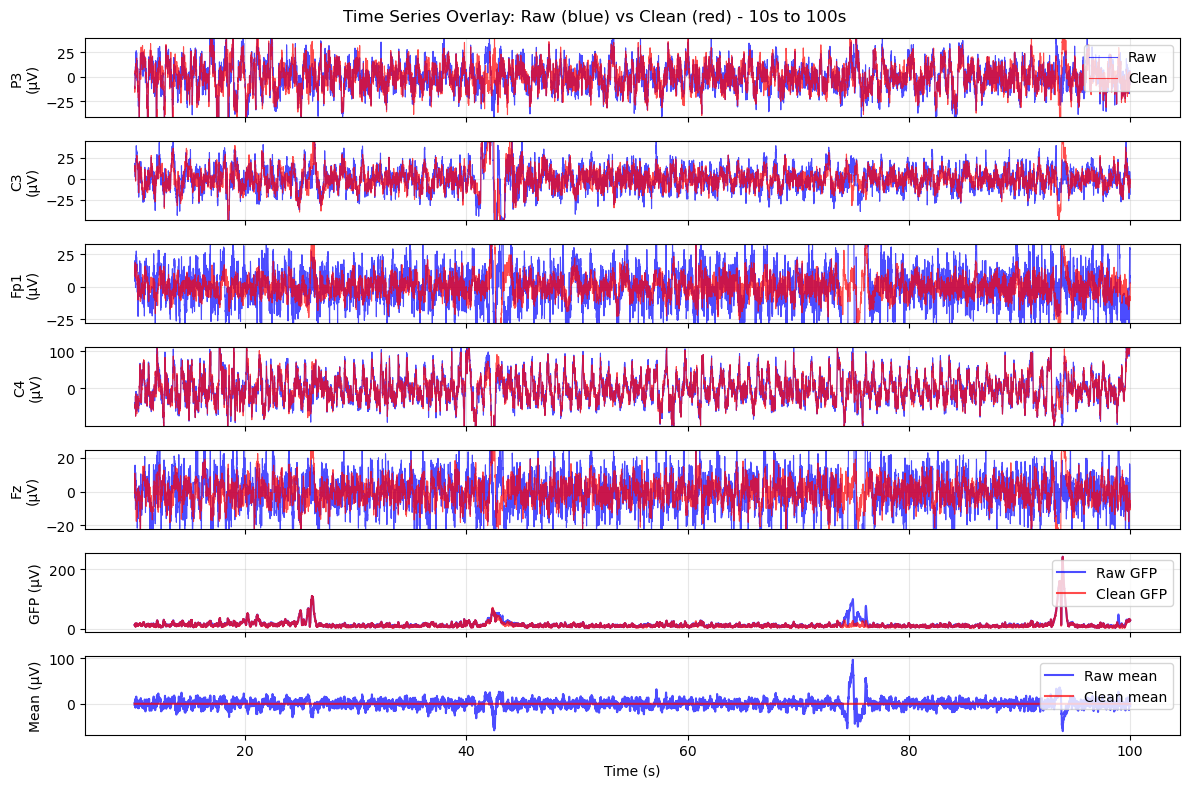

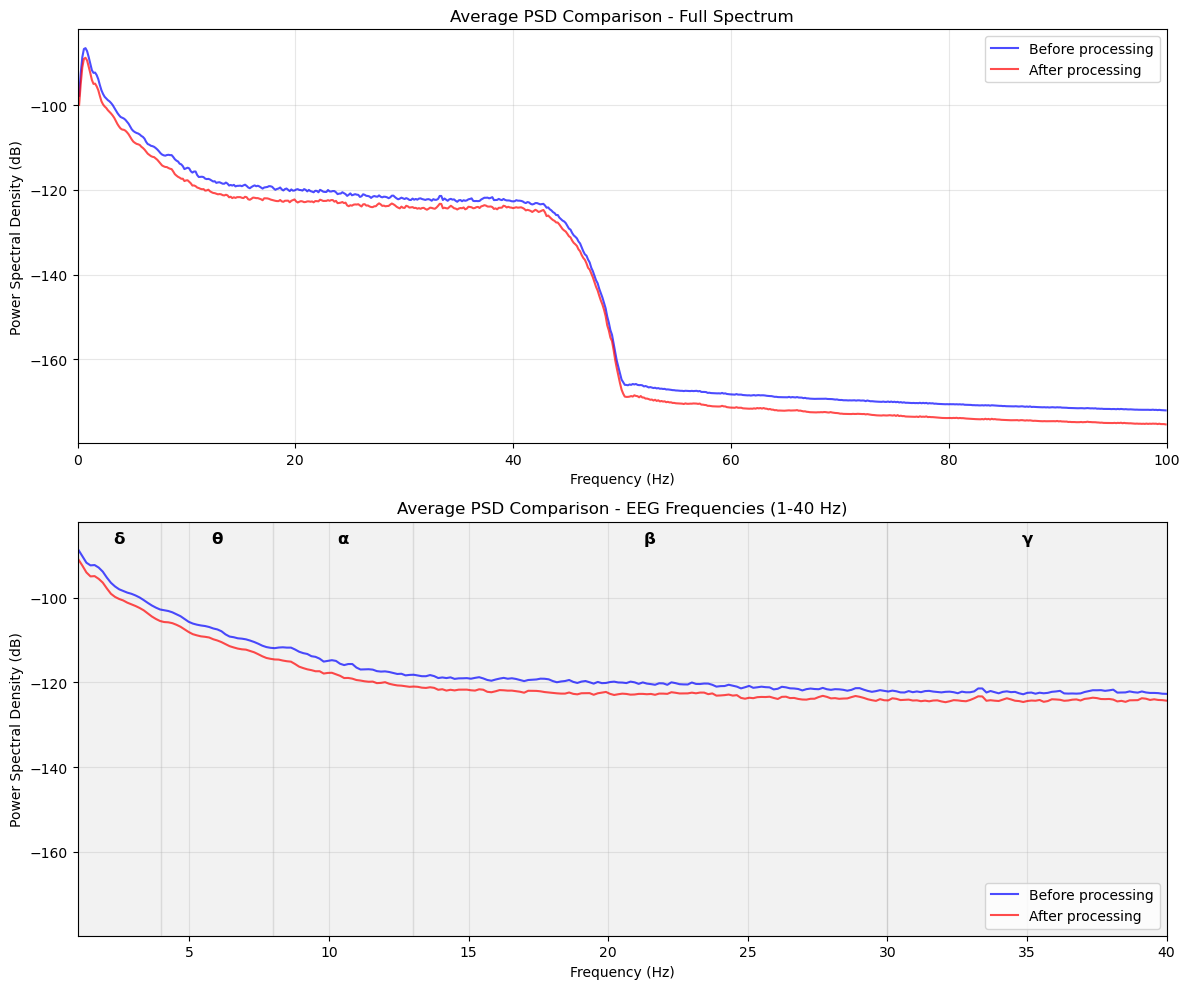

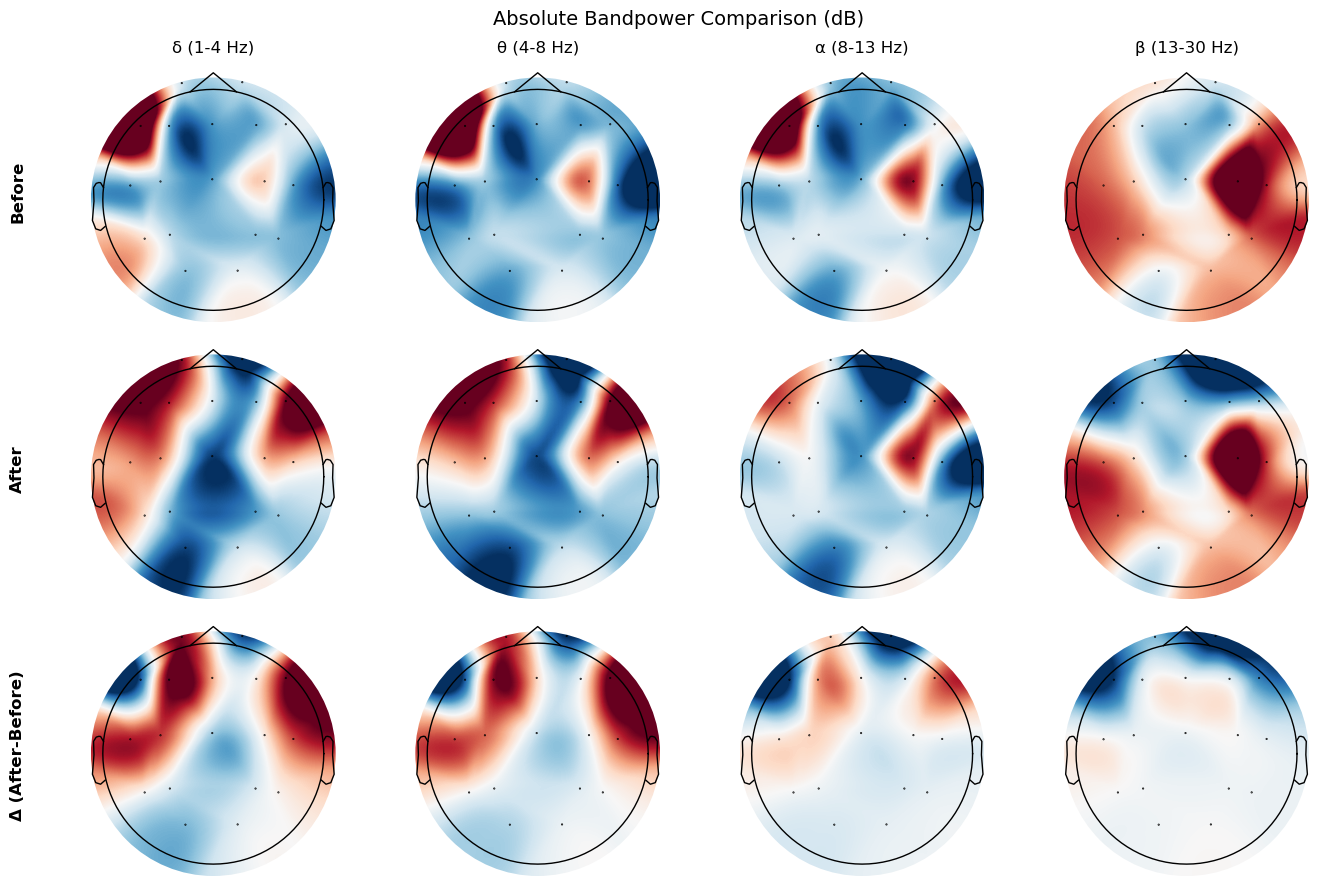

In [14]:
# Perform comprehensive before/after QC analysis

print("Performing comprehensive before/after QC analysis...")

# 1. Time series overlay
fig_overlay = plot_time_series_overlay(raw_filtered, raw_clean, tmin=10, tmax=100, n_channels=5)
add_fig(fig_overlay, 'Time Series Overlay - Raw vs Clean', '08_FinalQC')

# 2. PSD comparison
fig_psd_comp = plot_psd_comparison(raw_filtered, raw_clean)
add_fig(fig_psd_comp, 'PSD Comparison - Before vs After', '08_FinalQC')

# 3. Bandpower topomaps
fig_bandpower = plot_bandpower_topomaps(raw_filtered, raw_clean)
add_fig(fig_bandpower, 'Bandpower Topomaps - Before vs After', '08_FinalQC')

# 4. Compute spectral metrics
metrics_before = compute_spectral_metrics(raw_filtered)
metrics_after = compute_spectral_metrics(raw_clean)

# 5. Channel amplitude statistics
amp_stats_before = compute_channel_amplitude_stats(raw_filtered)
amp_stats_after = compute_channel_amplitude_stats(raw_clean)

# Create summary metrics dictionary
qc_metrics = {
    'file': str(FNAME),
    'n_channels': n_channels,
    'sfreq': float(raw.info['sfreq']),
    'duration_s': float(raw.times[-1]),
    'epochs_total': ar_results_1['n_epochs'],
    'epochs_bad_pass1': ar_results_1['n_bad_epochs'],
    'epochs_bad_pass2': ar_results_2['n_bad_epochs'],
    'epochs_good_frac_pass1': float(1 - ar_results_1['bad_epochs_frac']),
    'epochs_good_frac_pass2': float(1 - ar_results_2['bad_epochs_frac']),
    'ica_components_total': ica.n_components_,
    'ica_components_excluded': len(ica.exclude),
    'alpha_peak_before_hz': float(metrics_before['alpha_peak']),
    'alpha_peak_after_hz': float(metrics_after['alpha_peak']),
    '1f_slope_before': float(metrics_before['1f_slope']),
    '1f_slope_after': float(metrics_after['1f_slope']),
    'line_noise_ratio_before': float(metrics_before['line_noise_ratio']),
    'line_noise_ratio_after': float(metrics_after['line_noise_ratio']),
    'ptp_mean_before_uV': float(amp_stats_before['mean']),
    'ptp_mean_after_uV': float(amp_stats_after['mean']),
    'ptp_median_before_uV': float(amp_stats_before['median']),
    'ptp_median_after_uV': float(amp_stats_after['median'])
}

# Print summary
print("\nQC Metrics Summary:")
print(f"- Alpha peak: {metrics_before['alpha_peak']:.1f} Hz → {metrics_after['alpha_peak']:.1f} Hz")
print(f"- 1/f slope: {metrics_before['1f_slope']:.2f} → {metrics_after['1f_slope']:.2f}")
print(f"- Line noise ratio: {metrics_before['line_noise_ratio']:.2f} → {metrics_after['line_noise_ratio']:.2f}")
print(f"- Mean amplitude: {amp_stats_before['mean']:.1f} µV → {amp_stats_after['mean']:.1f} µV")

# Save metrics
metrics_csv = OUT_DIR / 'qc_metrics_summary.csv'
pd.DataFrame([qc_metrics]).to_csv(metrics_csv, index=False)
print(f"\nMetrics saved to: {metrics_csv}")

# Display key figures
display(fig_overlay, fig_psd_comp, fig_bandpower)


## 10. Generate Reports - HTML and PDF Output


In [15]:
# Helper functions for MNE Report compatibility across versions

def r_add_html(report, html: str, title: str, section: str):
    """Add an HTML snippet to a section (handles API differences)."""
    if hasattr(report, "add_html"):  # newer API
        report.add_html(html=html, title=title, section=section)
    elif hasattr(report, "add_htmls_to_section"):  # older API
        try:
            report.add_htmls_to_section(htmls=[html], captions=[title], section=section)
        except TypeError:
            report.add_htmls_to_section(htmls=[html], section=section)
    else:
        raise AttributeError("MNE Report: no method to add HTML found.")

def r_add_figure(report, fig, title: str, section: str):
    """Add a Matplotlib figure to a section (handles API differences)."""
    if fig is None:
        return
    
    # Check if figure is valid and not deleted
    try:
        # Try to access a basic property to check if object is still valid
        if hasattr(fig, '__len__'):
            _ = len(fig)
        elif hasattr(fig, 'axes'):
            _ = fig.axes
        else:
            # For Qt objects, check if they're still valid
            if hasattr(fig, 'isVisible'):
                if not hasattr(fig, 'isVisible') or str(type(fig)) == "<class 'NoneType'>":
                    print(f"Skipping deleted figure: {title}")
                    return
    except (RuntimeError, AttributeError) as e:
        if "deleted" in str(e) or "wrapped C/C++" in str(e):
            print(f"Skipping deleted Qt figure: {title}")
            return
        else:
            raise
    
    if hasattr(report, "add_figure"):
        try:
            report.add_figure(fig=fig, title=title, section=section)
        except TypeError:  # no section in this version
            try:
                report.add_figure(fig=fig, title=title)
                r_add_html(report, f"<p>See figure <b>{title}</b> in the top-level list.</p>",
                           title=f"{title} (note)", section=section)
            except RuntimeError as e:
                if "deleted" in str(e):
                    print(f"Skipping deleted figure during add: {title}")
                else:
                    raise
        except RuntimeError as e:
            if "deleted" in str(e):
                print(f"Skipping deleted figure during add: {title}")
            else:
                raise
    elif hasattr(report, "add_figs_to_section"):
        try:
            report.add_figs_to_section(figs=[fig], captions=[title], section=section)
        except RuntimeError as e:
            if "deleted" in str(e):
                print(f"Skipping deleted figure during add: {title}")
            else:
                raise
    else:
        raise AttributeError("MNE Report: no method to add figures found.")

def r_add_raw(report, raw, title: str, section: str, **kwargs):
    """Add Raw view; fall back if section is unsupported."""
    try:
        report.add_raw(raw=raw, title=title, section=section, **kwargs)
    except TypeError:
        report.add_raw(raw=raw, title=title, **kwargs)
        r_add_html(report, f"<p>Raw view <b>{title}</b> added at top level.</p>",
                   title="Raw view note", section=section)

def r_add_epochs(report, epochs, title: str, section: str, **kwargs):
    """Add epochs view; fall back if section is unsupported."""
    if not hasattr(report, "add_epochs"):
        return
    try:
        report.add_epochs(epochs=epochs, title=title, section=section, **kwargs)
    except TypeError:
        report.add_epochs(epochs=epochs, title=title, **kwargs)
        r_add_html(report, f"<p>Epochs view <b>{title}</b> added at top level.</p>",
                   title="Epochs view note", section=section)

def r_add_ica(report, ica, inst, title: str, section: str, **kwargs):
    """Add ICA summary; fall back if section is unsupported."""
    try:
        report.add_ica(ica=ica, inst=inst, title=title, section=section, **kwargs)
    except TypeError:
        report.add_ica(ica=ica, inst=inst, title=title, **kwargs)
        r_add_html(report, f"<p>ICA view <b>{title}</b> added at top level.</p>",
                   title="ICA view note", section=section)

def create_metrics_html(metrics: dict) -> str:
    """Create formatted HTML table for metrics."""
    rows = ""
    for key, value in metrics.items():
        # Format the key to be more readable
        formatted_key = key.replace('_', ' ').title()
        # Format the value based on type
        if isinstance(value, float):
            if 'frac' in key or 'ratio' in key:
                formatted_value = f"{value:.3f}"
            elif 'hz' in key.lower():
                formatted_value = f"{value:.1f} Hz"
            elif 'uv' in key.lower():
                formatted_value = f"{value:.1f} µV"
            else:
                formatted_value = f"{value:.2f}"
        else:
            formatted_value = str(value)
        
        rows += f"<tr><td>{formatted_key}</td><td>{formatted_value}</td></tr>"
    
    return f"""
    <h3>QC Metrics Summary</h3>
    <table style="border-collapse: collapse; font-family: Arial, sans-serif;">
        <tr style="background-color: #f2f2f2;">
            <th style="border: 1px solid #ddd; padding: 8px; text-align: left;">Metric</th>
            <th style="border: 1px solid #ddd; padding: 8px; text-align: left;">Value</th>
        </tr>
        {rows}
    </table>
    """


In [ ]:
# Generate comprehensive HTML report

from mne.report import Report

print("Generating comprehensive QC report...")

# Create report
report = Report(title="Mario EEG - Enhanced QC Report")

# Create overview HTML
overview_html = f"""
<h2>Processing Pipeline Overview</h2>
<h3>Dataset Information</h3>
<ul>
    <li><b>File:</b> {FNAME}</li>
    <li><b>Sampling Rate:</b> {raw.info['sfreq']:.1f} Hz</li>
    <li><b>EEG Channels:</b> {n_channels}</li>
    <li><b>Duration:</b> {raw.times[-1]/60:.1f} minutes</li>
</ul>

<h3>Processing Steps</h3>
<ol>
    <li><b>Filtering:</b> {HP}-{LP} Hz bandpass + {LINE_FREQ} Hz notch</li>
    <li><b>Epoching:</b> {EPOCH_DUR}s duration, {EPOCH_OVERLAP}s overlap</li>
    <li><b>First AutoReject:</b> {ar_results_1['n_bad_epochs']} bad epochs ({ar_results_1['bad_epochs_frac']*100:.1f}%)</li>
    <li><b>ICA:</b> {ica.n_components_} components, {len(ica.exclude)} excluded</li>
    <li><b>Second AutoReject:</b> {ar_results_2['n_bad_epochs']} bad epochs ({ar_results_2['bad_epochs_frac']*100:.1f}%)</li>
</ol>

<h3>Key Improvements</h3>
<ul>
    <li><b>Bad epochs reduced:</b> {ar_results_1['n_bad_epochs'] - ar_results_2['n_bad_epochs']} epochs</li>
    <li><b>Alpha peak preserved:</b> {metrics_before['alpha_peak']:.1f} Hz → {metrics_after['alpha_peak']:.1f} Hz</li>
    <li><b>Amplitude reduction:</b> {amp_stats_before['mean']:.1f} µV → {amp_stats_after['mean']:.1f} µV</li>
</ul>
"""

# Add sections in order
# 1. Overview
r_add_html(report, overview_html, title="Processing Overview", section=REPORT_SECTIONS["01_Setup"])

# 2. Raw data
r_add_raw(report, raw=raw, title="Raw EEG Data", section=REPORT_SECTIONS["02_Raw"], psd=True)

# 3. Add all figures by section
for section_key, section_title in REPORT_SECTIONS.items():
    if section_key in FIGS and FIGS[section_key]:
        print(f"Adding {len(FIGS[section_key])} figures to section: {section_title}")
        for fig_title, fig in FIGS[section_key]:
            r_add_figure(report, fig=fig, title=fig_title, section=section_title)

# 4. Add epochs visualization
r_add_epochs(report, epochs=epochs, title="Epoched Data - First Pass", 
             section=REPORT_SECTIONS["04_AutoReject1"])

# 5. Add ICA
r_add_ica(report, ica=ica, inst=good_epochs, 
          title="ICA Components and Properties",
          section=REPORT_SECTIONS["05_ICA"])

# 6. Add metrics table
metrics_html = create_metrics_html(qc_metrics)
r_add_html(report, metrics_html, title="Complete QC Metrics", 
           section=REPORT_SECTIONS["09_Metrics"])

# Save HTML report
HTML_PATH = OUT_DIR / "mario_qc_report_enhanced.html"
report.save(HTML_PATH, overwrite=True, open_browser=False)
print(f"\nHTML report saved to: {HTML_PATH.resolve()}")

###  Export to PdF needs many libraries check log after failing 

from weasyprint import HTML
HTML(filename=str(HTML_PATH)).write_pdf(str(PDF_PATH))
pdf_success = True
print(f"PDF report saved via WeasyPrint to: {PDF_PATH.resolve()}")




Generating comprehensive QC report...
Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embedding : bootstrap-table/bootstrap-table-export.min.js
Embedding : bootstrap-table/tableExport.min.js
Embedding : bootstrap-icons/bootstrap-icons.mne.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
Using matplotlib as 2D backend.
Using qt as 2D backend.
Effective window size : 6.827 (s)
Plotting power spectral density (dB=True).
Adding 4 figures to section: Raw Data Analysis
Adding 3 figures to section: Filtering
Adding 6 figures to section: First AutoReject Pass
Adding 1 figures to section: ICA Decomposition
Adding 3 figures to section: ICLabel Classification
Adding 3 figures to section: Second AutoReject Pass
Adding 3 figures to 

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x000001D963608B80>
Traceback (most recent call last):
  File "c:\Users\s\anaconda3\envs\eeg_analysis\lib\_weakrefset.py", line 40, in _remove
    self = selfref()
KeyboardInterrupt: 


    Applying projection operator with 1 vector (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
278 matching events found
No baseline correction applied
0 projection items activated
    Applying projection operator with 1 vector (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
278 matching events found
No baseline correction applied
0 projection items activated
    Applying projection operator with 1 vector (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
278 matching events found
No baseline correction applied
0 projection items activated
    Applying projection operator with 1 vector (pre-whitener application)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
278 matching events found
No baseline correction applied
0 projection items activated
    Applying projection operator

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   17.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:   17.5s


Overwriting existing file.
Saving report to : D:\Yann\neurotheque_resources\notebooks\preprocessing\qc_report_mario_enhanced\mario_qc_report_enhanced.html

HTML report saved to: D:\Yann\neurotheque_resources\notebooks\preprocessing\qc_report_mario_enhanced\mario_qc_report_enhanced.html
